In [114]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
from pandas.plotting import table # EDIT: see deprecation warnings below
import numpy as np
import missingno as miss
from dfply import *
import datetime as dt
import os

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.figure_factory as ff
# from pandas.table.plotting import table # EDIT: see deprecation warnings below

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate, cross_val_score, validation_curve # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT, export_graphviz
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA # LDA
# !{sys.executable} -m pip install xgboost
import xgboost as xgb

# For evaluating our model's performance
import sklearn.metrics as m
import graphviz
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, recall_score, accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler
# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance, partial_dependence, plot_partial_dependence

# Misc
import warnings
import sys
warnings.filterwarnings("ignore")

Data can be obtained here: https://www.kaggle.com/rahulsathyajit/wmo-hurricane-survival-dataset from Kaggle.

In [115]:
hurricane = pd.read_csv("World_MO_Hurricane_Survival.csv")
hurricane.head(5)

,ID,DOB,M_STATUS,SALARY,EDU_DATA,EMP_DATA,REL_ORIEN,FAV_TV,PREF_CAR,GENDER,...,FAV_COLR,NEWS_SOURCE,DIST_FRM_COAST,MNTLY_TRAVEL,GEN_MOVIES,FAV_SUBJ,ALCOHOL,FAV_SUPERHERO,Dist_Coast,Class
0,3345.0,7/22/1964,Married,0-100K,Post-Graduate,Unemployed,Believer,How I Met your mother,Ford,Male,...,Green,New York Times,10-25 KM,250-500 KM,Comedy,Art,Gin,The hulk,462.0,y
1,3346.0,9/9/1981,Unmarried,300k-500k,High-School,Employed,Believer,Big Bang Theory,Daimler-Benz,Male,...,Orange,Associated Press,60-80 KM,500-1000 KM,Thriller,Maths,Non Drinkers,Thor,269.0,y
2,3347.0,5/8/1978,Married,100k-300k,High-School,Employed,Believer,Flash,Suzuki,Male,...,White,Fox News,10-25 KM,0-250 KM,Horror,Chemistry,Rum,spiderman,1308.0,x
3,3348.0,6/21/1978,Unmarried,300k-500k,Graduate,Employed,Agnostic,Friends,Audi,Male,...,Green,BBC,0-10 KM,0-250 KM,Romantic,English,wine,Ironman,1039.0,y
4,3349.0,12/14/1968,Unmarried,500k-700k,High-School,Unemployed,Agnostic,Prison Break,BMW,Male,...,Black,Fox News,10-25 KM,0-250 KM,Thriller,Biology,Vodka,Thor,272.0,y


In [116]:
hurricane.shape

(5021, 24)

In [117]:
hurricane.dtypes

ID                float64
DOB                object
M_STATUS           object
SALARY             object
EDU_DATA           object
EMP_DATA           object
REL_ORIEN          object
FAV_TV             object
PREF_CAR           object
GENDER             object
FAV_CUIS           object
FAV_MUSIC          object
ENDU_LEVEL         object
FAV_SPORT          object
FAV_COLR           object
NEWS_SOURCE        object
DIST_FRM_COAST     object
MNTLY_TRAVEL       object
GEN_MOVIES         object
FAV_SUBJ           object
ALCOHOL            object
FAV_SUPERHERO      object
Dist_Coast        float64
Class              object
dtype: object

We have a lot of categorical variables.

## Converting The Dependent Variable To Numeric

(Because converting a binary variable into numbers is helpful)

In [118]:
# Before: Survival rate is coded x or y. Not intuitive or helpful.
hurricane.Class.unique()

array(['y', 'x'], dtype=object)

In [119]:
# X = will survive
# Y = Did not survive
hurricane.Class = 1.0*(hurricane.Class == "y")
hurricane.Class.head()

0    1.0
1    1.0
2    0.0
3    1.0
4    1.0
Name: Class, dtype: float64

0 means that the individual survived; 1 means that the person died.

<AxesSubplot:>

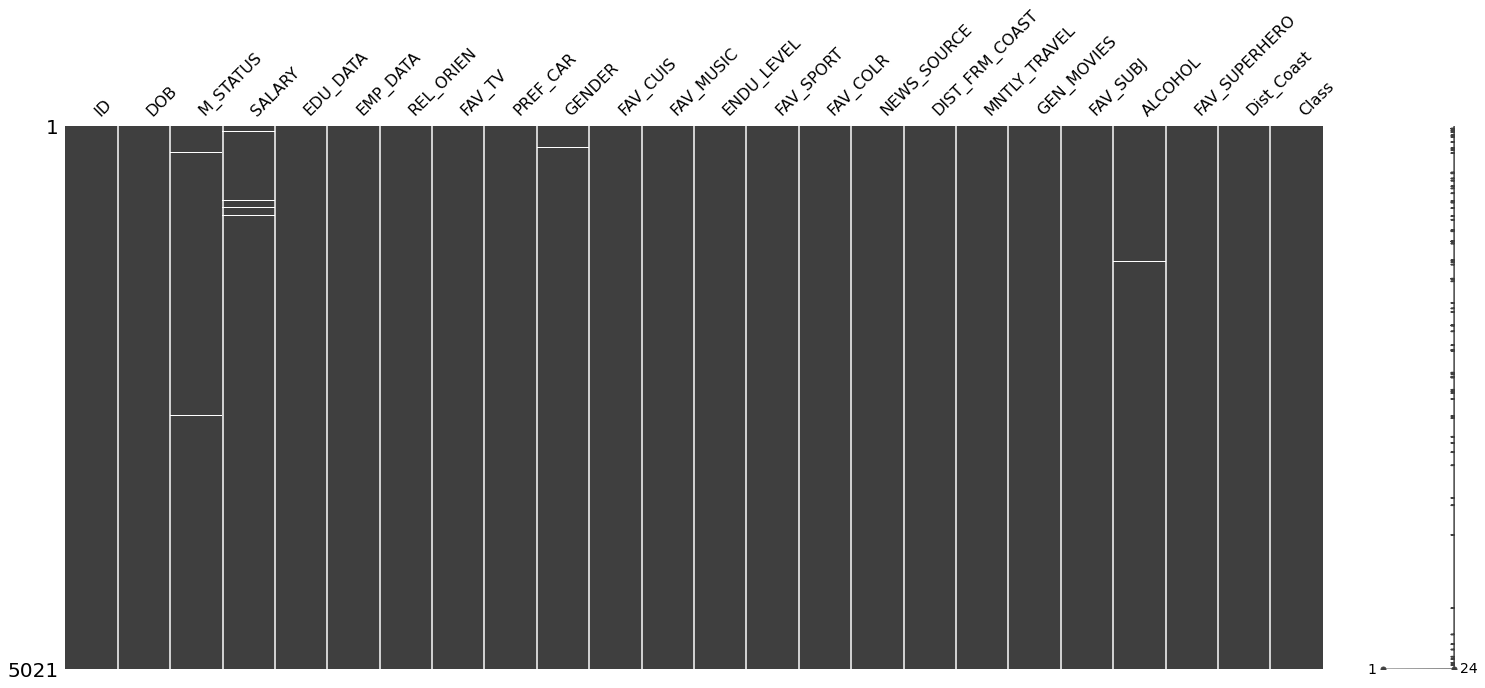

In [120]:
# Seeing any notorious, significant missingness
miss.matrix(hurricane)

It looks like we have some NAs.

In [121]:
print("Total NAs: ",sum(hurricane.isna().sum()))
hurricane.isna().sum()

Total NAs:  92


ID                 1
DOB                1
M_STATUS          24
SALARY            19
EDU_DATA           5
EMP_DATA           1
REL_ORIEN          1
FAV_TV             1
PREF_CAR           1
GENDER            17
FAV_CUIS           1
FAV_MUSIC          1
ENDU_LEVEL         1
FAV_SPORT          1
FAV_COLR           1
NEWS_SOURCE        1
DIST_FRM_COAST     1
MNTLY_TRAVEL       6
GEN_MOVIES         1
FAV_SUBJ           1
ALCOHOL            4
FAV_SUPERHERO      1
Dist_Coast         1
Class              0
dtype: int64

92 total NAs is a small number compared to the 5000+ rows in the dataset, so we can afford to eradicate those rows with NAs. 

Also, it appears that there is one row with all NAs. We can eradicate that row.

In [122]:
# I noticed that DOB has only 1 NA, so I want all the rows in DOB who are not NA
# In this way, I eradicate that row who has a lot of NAs
hurricane = hurricane[hurricane["DOB"].notna()]

print("Hurricane dataset size: ", hurricane.shape)
print("Total NAs: ", sum(hurricane.isna().sum()))
hurricane.isna().sum()

Hurricane dataset size:  (5020, 24)
Total NAs:  69


ID                 0
DOB                0
M_STATUS          23
SALARY            18
EDU_DATA           4
EMP_DATA           0
REL_ORIEN          0
FAV_TV             0
PREF_CAR           0
GENDER            16
FAV_CUIS           0
FAV_MUSIC          0
ENDU_LEVEL         0
FAV_SPORT          0
FAV_COLR           0
NEWS_SOURCE        0
DIST_FRM_COAST     0
MNTLY_TRAVEL       5
GEN_MOVIES         0
FAV_SUBJ           0
ALCOHOL            3
FAV_SUPERHERO      0
Dist_Coast         0
Class              0
dtype: int64

We now have 69 NAs, compared to our previous 92 NAs. But let's delete all the NAs anyways.

In [123]:
# Dropping rows who have NAs
hurricane.dropna(inplace = True)
# reset index
# drop = T so you drop the "old" indexes
hurricane.reset_index(inplace = True, drop = True)
hurricane.shape
# hurricane.shape
# RF, DTs, and LDAs work okay with NAs

(4951, 24)

We still have close to 5000 rows. Pretty good.

## Spawn An Age Column

To create an age column, I will subtract each date of birth from a baseline date. Since this dataset was published on 2017 December 19, I will use that date as a baseline for calculating age.

In [124]:
# Changing the Date Of Birth column into a datetime object (format: year/month/day)
# hurricane["DOB"] = pd.to_datetime(hurricane["DOB"], format='%m/%d/%y')

def spawnAge(hurricane, columnName, today = dt.date(2017, 12, 19)):
    '''
    Spawns an age column (from a date of birth column)
    
    @param hurricane the dataframe
    @param columnName the name of the column to spawn the age on
    @return the finished dataframe
    '''

    hurricane[columnName] = hurricane[columnName].apply(lambda row: dt.datetime.strptime(row, "%m/%d/%Y") if row is not np.nan else row)
    # Setting today's date
    today = dt.date(2017, 12, 19)

    # temp["diffDays"] = (pd.to_datetime(temp.today) - pd.to_datetime(temp.DOB)).dt.days
    # temp["age"] = np.floor(temp.diffDays/365)
    # temp.head(6)

    # People's age in days
    diffDays = (pd.to_datetime(today) - hurricane[columnName]).dt.days
    
    # diffDays = hurricane.DOB.apply(lamnda birth: pd.to_datetime(today) - birth if type(birth) == "Timestamp" else birth)
    
    #People's age in years
    hurricane["age"] = np.floor(diffDays/365)
    
    # drop the DOB column
    hurricane.drop(columns = [columnName], axis = 1, inplace=True)
    return hurricane
#     return hurricane
# format: yyyy-mm-dd?
# Now the DOB column is a datetime object
# spawnAge()
# Consider: local parameters. Think of Sophie

In [125]:
# Spawning age column
hurricane = spawnAge(hurricane, "DOB")
hurricane["age"].head()

0    53.0
1    36.0
2    39.0
3    39.0
4    49.0
Name: age, dtype: float64

## Eradicating The ID Variable

We can do this because the ID variable differentiates each individual from one another. No 2 individuals will have the same ID number.

In [126]:
hurricane.drop(columns = ["ID"], axis = 1, inplace = True)

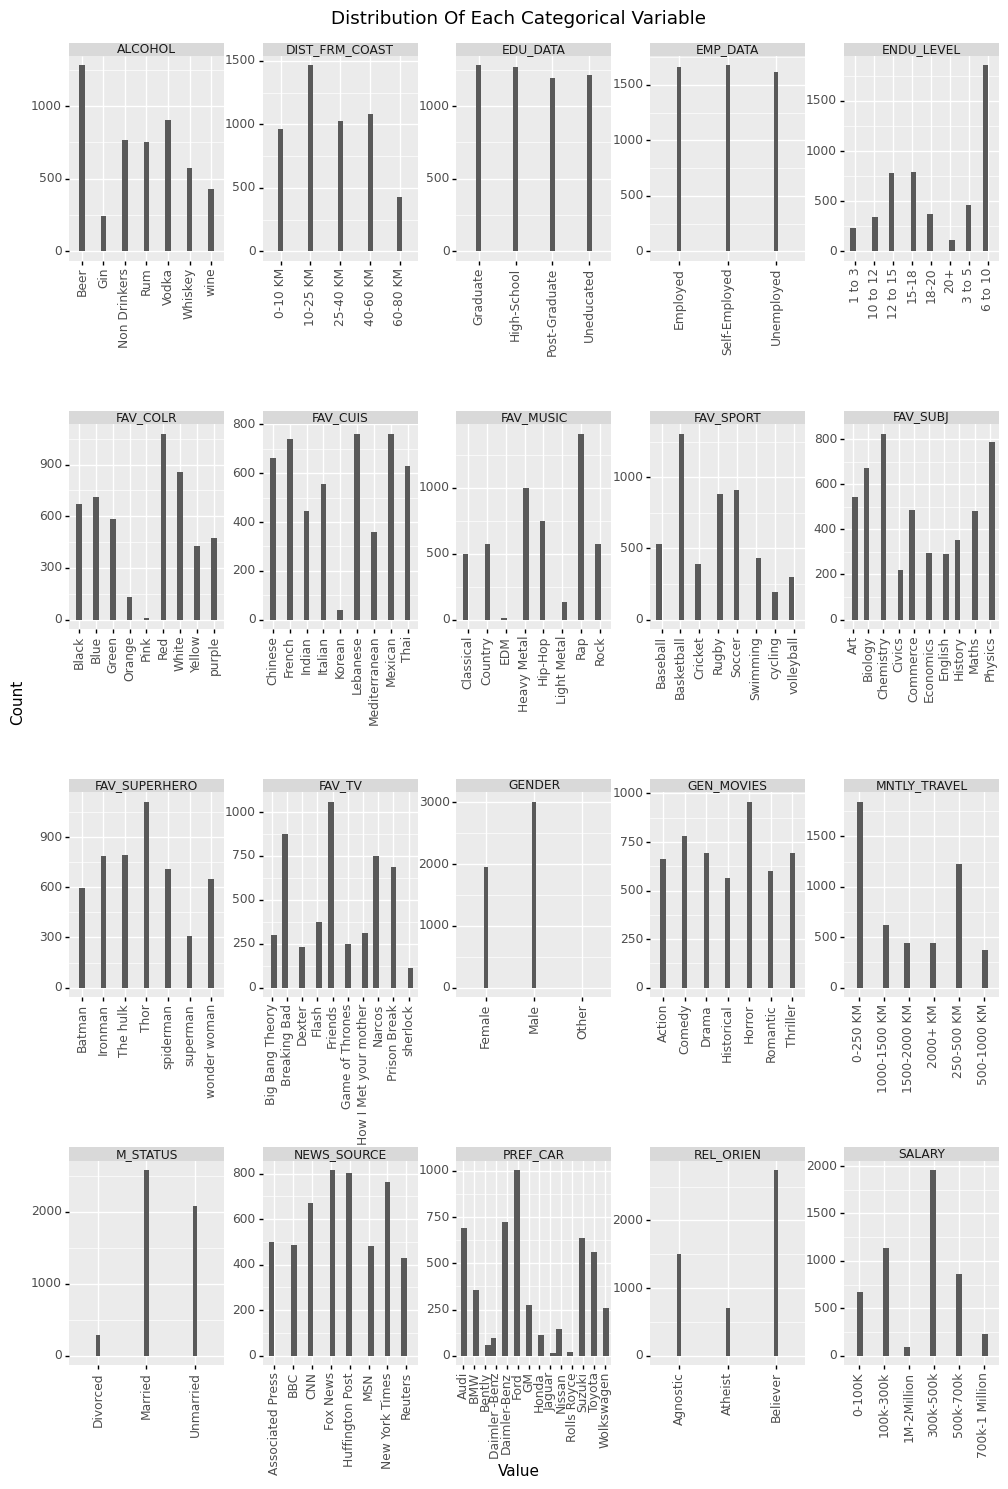

<ggplot: (127916758697)>


In [127]:
# Let's learn from the data
# Plot the continuous Variables 
d = hurricane.select_dtypes(include="object").melt()
#d["variable"] = d.columns
#d["value"] = d["variable"].mean
p = (
    d >>
#     mask(X.variable != "DOB") >>
    ggplot(aes(x = "value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    labs(
        x = "Value",
        y = "Count",
        title = "Distribution Of Each Categorical Variable"
    ) +
    theme(figure_size=(12,17),
          subplots_adjust={'wspace':0.25,
                             "hspace": 0.8}) +
    theme(axis_text_x = element_text(angle = 90))
)
ggsave(plot = p, filename = "Distribution_Category_Vars")
print(p)

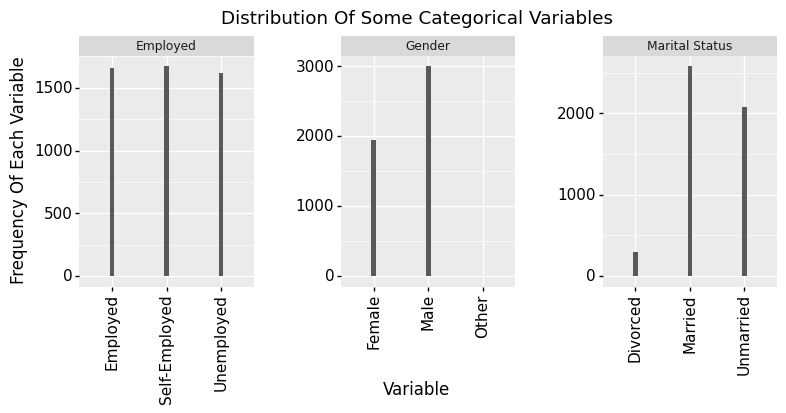

<ggplot: (127921384735)>


In [128]:
# Let's learn from the data
# Plot the continuous Variables 
d = hurricane.select_dtypes(include="object").rename(columns= {"GENDER" : "Gender",
                                                                "DIST_FRM_COAST" : "Kilometers From Coast",
                                                                "M_STATUS" : "Marital Status",
                                                                "EMP_DATA" : "Employed"}).dropna().melt()
#d["variable"] = d.columns
#d["value"] = d["variable"].mean
p = (
    d >>
    mask((X.variable == "Gender") | (X.variable == "Employed") | (X.variable == "Marital Status")) >>
#     mutate_if(X.variable == "GENDER", "gender")>>
#     mutate(gender if X.variable == )
    ggplot(aes(x = "value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free', labeller= "label_value") +
    labs(
        x = "Variable",
        y = "Frequency Of Each Variable",
        title = "Distribution Of Some Categorical Variables"
    ) +
    theme(figure_size=(9,3),
          subplots_adjust={'wspace':0.5,
                             "hspace": 0.5}) +
    theme(axis_text_x = element_text(angle = 90),
         axis_text = element_text(size = 11, color = "black"),
         axis_title = element_text(size = 12, color = "black"))
)
ggsave(plot = p, filename = "Distribution_Some_Category_Vars")
print(p)

There seems to be a slight imbalance between males and females. Female to male ratio appears to be 2:3. A closer inspection reveals that there are 2 individuals who identify as non-binary.

There are fortunately equal distributions of employment.

There appears to be slightly more individuals who are married than those who are unmarried. However, there is also a dearth in people who are divorced.

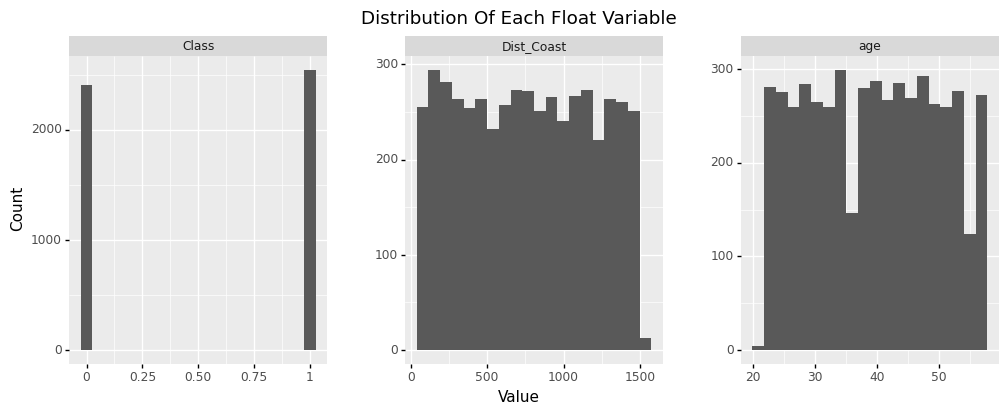

<ggplot: (127917090208)>


In [130]:
# Distribution Of Float Variables
d = hurricane.select_dtypes(include="float").melt()
p = (
    d >>
#     mask((X.variable != "ID") | (X.variable == M_STATUS)) >>
    mask(X.variable != "ID") >>
    ggplot(aes(x = "value")) +
    geom_histogram(bins = 20) +
    facet_wrap("variable",scales='free') +
    labs(
        x = "Value",
        y = "Count",
        title = "Distribution Of Each Float Variable"
    ) +
    theme(figure_size=(12,4),
          subplots_adjust={'wspace':0.3,
                             "hspace": 4}) +
    theme(axis_text_x = element_text(angle = 0))
)
ggsave(plot = p, filename = "Distribution_Float_Vars")
print(p)

There appears to be equal balance between individual who survived and those who died. The distributions for distance of the coast and age appear to be mostly uniform.

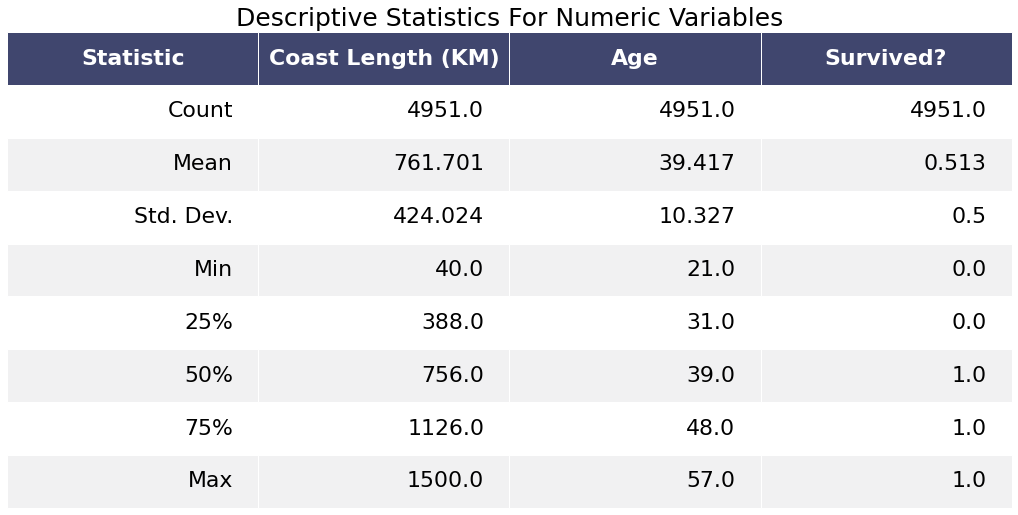

In [131]:
# Creating a descriptive summary statistics
p = hurricane.rename(
    # Renaming the columns to be more standard English
    columns = 
   {"Dist_Coast" : "Coast Length (KM)",
   "age" : "Age",
   "Class" : "Survived?"} 
)[["Coast Length (KM)", "Age", "Survived?"]].describe().round(3)

# Adding a column for "Statistic"
p = (
    p >>
    mutate(Statistic = ["Count", "Mean", "Std. Dev.", "Min", "25%", "50%", "75%", "Max"]) >>
    select(X.Statistic, "Coast Length (KM)", "Age", "Survived?")
)

# ax = plt.subplot(433, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(ax, p)  # where df is your data frame
# plt.savefig('Descriptive_Stats.png', bbox_inches='tight')

## FF
# fig =  ff.create_table(df)
# fig.update_layout(
#     autosize=False,
#     width=500,
#     height=200,
# )
# fig.write_image("table_plotly.png", scale=2)
# fig.show()



def render_mpl_table(data, col_width=2.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + 5 + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
#     print(mpl_table)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(p, header_columns=0, col_width=2.0, font_size = 22)
plt.title("Descriptive Statistics For Numeric Variables", fontsize = 25)
fig.savefig("Descriptive_Stats.png", bbox_inches = "tight")

Note that kilometers from the coast and age are on different scales. Age ranges from 21 to 57 while kilometers from the coast range from 40 km to 1500 km. Note that the dataset does not have any youth or elders.

Fortunately, there appears to be an equal distribution of those who survived and those who did not.

## Re-Categorization (Of Inherent Ordering)

In [132]:
def toCategorizeNumerical(df, columnName, orderedCategory):
    '''
    Re-Categorizes inherently ordered categories into numbers
    
    @param df the given dataframe that has the data
    @param columnName the name of the column/variable to re-categorize
    @param orderedCategory the list of categories, ordered.
    @return the new df, with a re-categorized variable
    '''
    
    # How to reorder your categories to follow inherent ordering
    cat_types = CategoricalDtype(categories = orderedCategory, ordered = True)
    
    # Force the given column to be in this inherent order,
    # then turn it into its internal numeric number
    df[columnName] = df[columnName].astype(cat_types).cat.codes
    return df
    

## Endurance Categorization

In [133]:
# Categories of endurance
orderedCategories = ['1 to 3', '3 to 5',  '6 to 10', '10 to 12', '12 to 15', '15-18', '18-20', '20+' ]
hurricane = toCategorizeNumerical(hurricane, "ENDU_LEVEL", orderedCategories)
hurricane["ENDU_LEVEL"].value_counts()

2    1851
5     794
4     780
1     466
6     372
3     341
0     232
7     115
Name: ENDU_LEVEL, dtype: int64

# Education Recategorize

In [134]:
hurricane.EDU_DATA.unique()

array(['Post-Graduate', 'High-School', 'Graduate', 'Uneducated'],
      dtype=object)

In [135]:
orderedCategories = ["Uneducated", "High-School", "Graduate", "Post-Graduate"]
hurricane = toCategorizeNumerical(hurricane, "EDU_DATA", orderedCategories)
print(hurricane.EDU_DATA.value_counts())

2    1279
1    1270
0    1211
3    1191
Name: EDU_DATA, dtype: int64


## Salary Re-categorization

In [136]:
orderedCategories = ['0-100K', '100k-300k', '300k-500k' , '500k-700k', '700k-1 Million', '1M-2Million']
hurricane = toCategorizeNumerical(hurricane, "SALARY", orderedCategories)
print(hurricane.SALARY.value_counts())

2    1958
1    1132
3     861
0     677
4     233
5      90
Name: SALARY, dtype: int64


## Monthly Travel Re-Categorization

In [137]:
orderedCategories = ['0-250 KM', '250-500 KM', '500-1000 KM', '1000-1500 KM', '1500-2000 KM', '2000+ KM']
hurricane = toCategorizeNumerical(hurricane, "MNTLY_TRAVEL", orderedCategories)
hurricane.MNTLY_TRAVEL.value_counts()

0    1844
1    1224
3     621
4     446
5     440
2     376
Name: MNTLY_TRAVEL, dtype: int64

## Distance From Coast Re-Categorization

In [138]:
(
    hurricane >>
    select(X.DIST_FRM_COAST, X.Dist_Coast)
)

,DIST_FRM_COAST,Dist_Coast
0,10-25 KM,462.0
1,60-80 KM,269.0
2,10-25 KM,1308.0
3,0-10 KM,1039.0
4,10-25 KM,272.0
...,...,...
4946,60-80 KM,1249.0
4947,60-80 KM,130.0
4948,0-10 KM,417.0
4949,0-10 KM,391.0


The two columns don't actually match up. This could mean that both columns mean different things: distance of the coast vs. distance from the coast.

In [139]:
# Re-Categorizing Distance
orderedCategories = ['0-10 KM', '10-25 KM', '25-40 KM', '40-60 KM', '60-80 KM']
hurricane = toCategorizeNumerical(hurricane, "DIST_FRM_COAST", orderedCategories)
hurricane.DIST_FRM_COAST.unique()
# Eradicating that numerical column
# hurricane.drop(["Dist_Coast"], axis = 1, inplace = True)


array([1, 4, 0, 2, 3], dtype=int8)

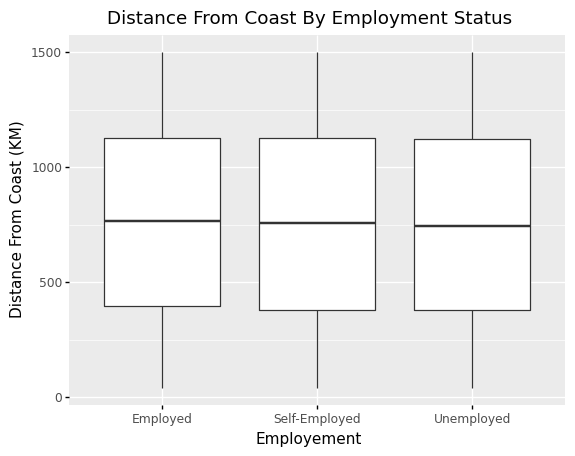

<ggplot: (127916805389)>

In [140]:
# Employment Vs Distance From Coast
p = (
    hurricane >>
#     select(X.EDU_DATA,  X.Dist_Coast) >>
    group_by(X.EMP_DATA) >>
#     summarize(meanDistance = mean(X.Dist_Coast)) >>
    ggplot(aes(x = "EMP_DATA", y = "Dist_Coast")) +
    geom_boxplot() +
    labs(
        x = "Employement",
        y = "Distance From Coast (KM)",
        title = "Distance From Coast By Employment Status"
    )
)
p

The distributions of distance from the coast appear equal for all different employment statuses.

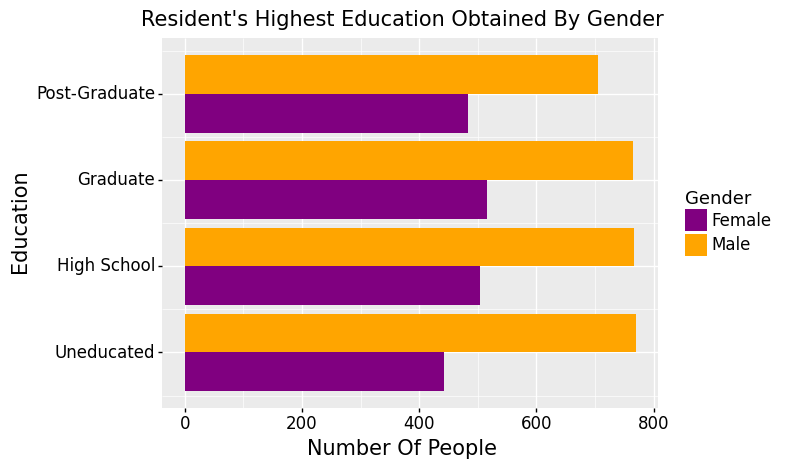

<ggplot: (127924924700)>


In [141]:
# Education by gender?
p = (
    hurricane >>
    select(X.GENDER, X.EDU_DATA) >>
    mask((X.GENDER.notna()) & (X.GENDER != "Other")) >>
    mask(X.EDU_DATA != -1) >>
    group_by(X.GENDER, X.EDU_DATA) >>
    summarize(count = n(X.EDU_DATA)) >>
    ggplot(aes(x = "EDU_DATA", y = "count", fill = "GENDER")) +
    geom_bar(stat = "identity", position = "dodge") +
    coord_flip() +
    scale_x_continuous(
         breaks = [0, 1, 2, 3],
        labels = ["Uneducated", "High School", "Graduate", "Post-Graduate"]
    ) +
    # Do not include the non-binary label (sorry!)
    scale_fill_manual(
        breaks = ["Female", "Male"],
        labels = ["Female", "Male"],
        values = ["purple", "orange"]
    ) +
    # Spawning a heatmap
#     ggplot(aes(x = "GENDER", y = "EDU_DATA", fill = "count")) +
#     geom_tile() +
#     
#     scale_y_continuous(
#         breaks = [0, 1, 2, 3],
#         labels = ["Uneducated", "High School", "Graduate", "Post-Graduate"]
#     )
    labs(
        x = "Education",
        y = "Number Of People",
        fill = "Gender",
        title = "Resident's Highest Education Obtained By Gender"
    ) +
    theme(axis_text= element_text(size = 12, color = "black")) +
    theme(axis_title = element_text(size = 13, color = "black")) +
    theme(legend_text=element_text(size = 12),
         legend_title = element_text(size = 13),
         title=element_text(size = 15))
)
ggsave(plot = p, filename = "Education_By_Gender")
print(p)

Here is the concentration of females and males for each education level obtained. For every education category, there is a disproportionately larger number of males than females, though, that could occur because there is about a 3:2 ratio of males to females in the data.

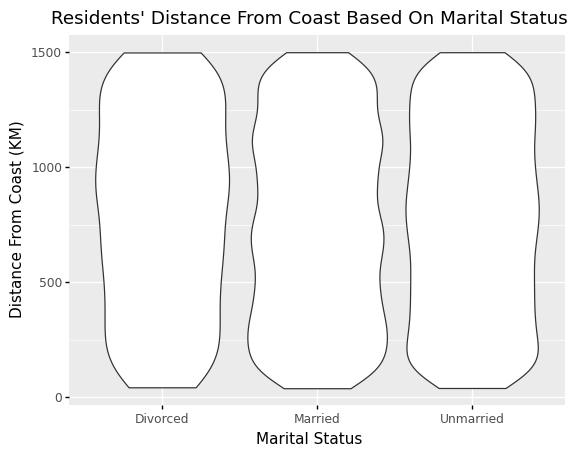

<ggplot: (127917998047)>

In [142]:
p = (
    hurricane >>
    mask(X.M_STATUS.notna()) >>
    ggplot(aes(y = "Dist_Coast", x = "M_STATUS")) +
#     geom_bar(stat = "identity")
    geom_violin() +
    labs(
        x = "Marital Status",
        y = "Distance From Coast (KM)",
        title = "Residents' Distance From Coast Based On Marital Status"
    )
)
p

The distributions of distance from the coast appear equal for individuals from all marital statuses. An individual who is divorced is no more likely than someone who is married to live, say, 1000 km from the coast.

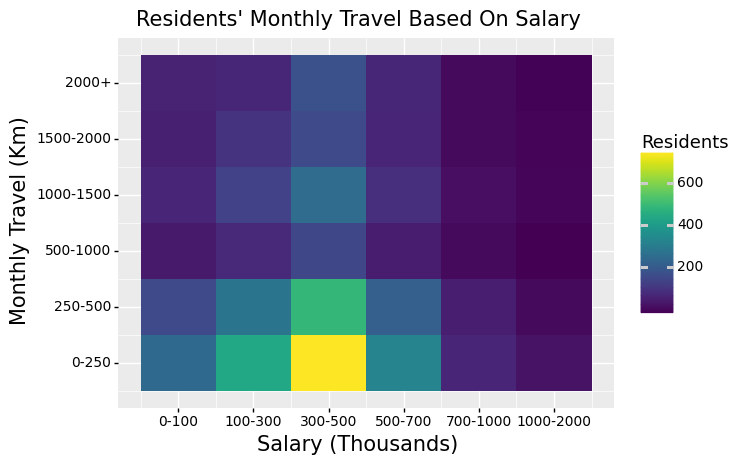

<ggplot: (127925049820)>


In [143]:
# Graphing salary with monthly travel
p = (
    hurricane >>
#     mutate(salary = ["1000K-2000K" if X.SALARY == "1M-2Million" else X.SALARY]) >>
    mask(X.SALARY != -1) >>
    mask(X.MNTLY_TRAVEL != -1) >>
    group_by(X.SALARY, X.MNTLY_TRAVEL) >>
    summarize(count = n(X.MNTLY_TRAVEL)) >>
    ggplot(aes(y = "MNTLY_TRAVEL", x = "SALARY", fill = "count")) +
    geom_tile() +

    # Re-labeling the Y axis
    scale_y_continuous(
        breaks = [0, 1, 2, 3, 4, 5],
        
        labels = ['0-250', '250-500', '500-1000', '1000-1500', '1500-2000', '2000+']
    ) +
    
    # Re-labeling the X-axis
    scale_x_continuous(
        breaks = [0, 1, 2, 3, 4, 5],
        labels = ['0-100', '100-300', '300-500' , '500-700', '700-1000', '1000-2000']
    ) +
    
    # More labels
    labs(
        x = "Salary (Thousands)",
        y = "Monthly Travel (Km)",
#         fill = "Number Of People",
        title = "Residents' Monthly Travel Based On Salary",
        fill = "Residents"
    ) +
    theme(axis_text= element_text(size = 10, color = "black")) +
    theme(axis_title = element_text(size = 13, color = "black")) +
    theme(legend_text=element_text(size = 10),
         legend_title = element_text(size = 13),
         title=element_text(size = 15))
)

ggsave(plot = p, filename = "Salary_With_Monthly_Travel")
print(p)

Note that there is a disproportionately huge number of people with salaries between \\$300K and \\$500K who do not go on monthly travel at all. Overall, most of the residents had salaries between 300-500K and do not usually travel at all.

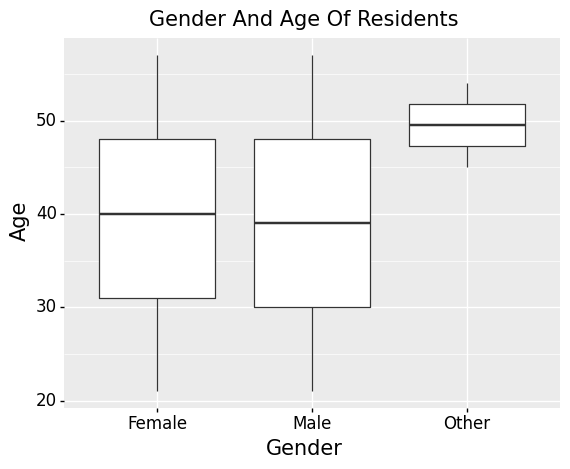

<ggplot: (127925970481)>


In [144]:
# Graphing age with gender
p = (
    hurricane >>
#     mutate(salary = ["1000K-2000K" if X.SALARY == "1M-2Million" else X.SALARY]) >>
    mask(X.GENDER.notna()) >>
    group_by(X.GENDER) >>
    group_by(X.Class) >>
#     summarize(count = n(X.ID)) >>
    ggplot(aes(x = "GENDER", y = "age")) +
#     geom_point(position = "jitter") +
#     geom_violin()  ++
    geom_boxplot() +
#     geom_bar(stat = "identity") +
    labs(
        x = "Gender",
        y = "Age",
#         color = "Survived?",
        title = "Gender And Age Of Residents"
    ) +
    theme(axis_text= element_text(size = 12, color = "black")) +
    theme(axis_title = element_text(size = 13, color = "black")) +
#     theme(legend_text=element_text(size = 12),
#          legend_title = element_text(size = 13)) +
    theme( title=element_text(size = 15))
)

ggsave(plot = p, filename = "Gender_And_Age")
print(p)

Note that the distribution of age for people who identify as non-binary is narrow because there are only 2 non-binary individuals included in the dataset. Females and males had the same age distribution. Females' mean age is around 40, and the male's mean age is about 39 years. Again, note that the dataset did not include youth, infants, or elders (people at least 60 years old).

# Dummy Variables

In [145]:
# # hurricane[["ID", "DOB", "M_STATUS"]]
# # columnsToEncode = 
# categorical_feature_mask = hurricane.dtypes=="category"
# categorical_features = hurricane.columns[categorical_feature_mask].tolist()
# myOneHotEncoded = OneHotEncoder(handle_unknown = "error", drop = "first")
# myOneHotEncoded.fit(hurricane[categorical_features])



# # Transformed Hurricane

# transHurr = myOneHotEncoded.transform(hurricane[categorical_features])
# myOneHotEncoded.categories_

In [146]:
# Daniel
#hurricane = pd.read_csv("World_MO_Hurricane_Survival.csv")
# hurricane.replace("nan", np.nan, inplace = True)
# hurricane.replace("", np.nan, inplace = True)
# hurricane.dropna(inplace= True)
# spawnAge()
# hurricane.Class = 1.0 * (hurricane.Class == "y")

# # reset index
# # drop = T so you drop the "old" indexes
# hurricane.reset_index(inplace = True, drop = True)
# hurricane.info()

In [147]:
# Daniel The MVP
# One-hot encoding


def toLabelBinarize(hurricane):
    '''
    Spawns dummy variables for columns without inherent ordering
    
    @param hurricane the dataframe
    @return the dataframe (after the columns have been labelized binarized)
    '''
    
    for col in hurricane.columns:
    #     print(hurricane[col].dtypes)
    #     print(sum(hurricane[col] == "nan")
    # I do not want to spawn dummy variables for variables who already have inherent ordering.
        if hurricane[col].dtypes == object and col not in orderedColumns:
    #         print(hurricane[col].value_counts())

            # Force the column to be a string, not mixed
            hurricane[col] = hurricane[col].apply(lambda x: str(x))
    #         print(hurricane[col].isna().sum())
    #         print(hurricane[col].unique())


            # Spawn a label binarizer that does one hot encoding
            enc = LabelBinarizer()
    #         all_labels = hurricane[col]
    #         enc.fit(all_labels)

            # Conerts a numpy array into a list
            # list contains all the different..categories per column
            # Transformed
            # Mon, Tues, Wed
            # isMon, isTues, isWed
            transformed = enc.fit_transform(hurricane[col]) # a numpy array
    #         print(enc.classes_.tolist())
    #         print(transformed.shape)
            op_df = pd.DataFrame(transformed, columns = enc.classes_.tolist())

            # Drops the first column/reference column
            op_df.drop(columns = [op_df.columns[0]], inplace = True)

            # Drop that original colomn
            hurricane = hurricane.drop(columns=[col])       

            # Concatenate the rest of the columns
            hurricane = pd.concat([hurricane, op_df], axis=1)
    return hurricane

        
#         Consider eradicating it
#         op_test = enc.transform(test_x[col])
#         test_df = pd.DataFrame(op_test)
#         test_x = pd.concat([test_x, test_df], axis=1)
#         test_x = test_x.drop(columns=[col])
# hurricane.dropna(inplace= True)

# These are the columns I do not want to turn into dummies.
orderedColumns = ["SALARY", "EDU_DATA", "ENDU_LEVEL", "DIST_FRM_COAST", "MNTLY_TRAVEL"]

hurricane = toLabelBinarize(hurricane)

In [148]:
hurricane.corr()

,SALARY,EDU_DATA,ENDU_LEVEL,DIST_FRM_COAST,MNTLY_TRAVEL,Dist_Coast,Class,age,Married,Unmarried,...,Rum,Vodka,Whiskey,wine,Ironman,The hulk,Thor,spiderman,superman,wonder woman
SALARY,1.000000,-0.001474,0.014725,0.001119,-0.004602,0.015712,-0.010962,0.007882,0.016439,-0.021819,...,-0.003074,0.004408,-0.040284,0.008621,0.009554,-0.022395,-0.003735,0.010566,-0.000785,0.005504
EDU_DATA,-0.001474,1.000000,0.011898,-0.001404,0.017535,-0.001648,-0.012770,-0.018633,-0.018007,0.013412,...,0.001207,0.006226,-0.015445,0.008568,0.000029,0.002035,0.003822,-0.003044,0.020939,-0.017165
ENDU_LEVEL,0.014725,0.011898,1.000000,0.447032,0.212273,-0.015415,0.007280,-0.014600,-0.006664,0.010599,...,0.118606,-0.105724,-0.264327,0.010901,-0.002231,-0.009650,0.013049,0.001734,-0.007126,0.003845
DIST_FRM_COAST,0.001119,-0.001404,0.447032,1.000000,0.341483,-0.012346,-0.018296,-0.021236,-0.023138,0.016785,...,0.068079,-0.042452,-0.152203,0.008584,0.002365,-0.010406,0.019733,0.005802,-0.008358,-0.000542
MNTLY_TRAVEL,-0.004602,0.017535,0.212273,0.341483,1.000000,-0.006145,-0.016426,-0.019842,0.022443,-0.031499,...,0.051849,-0.055130,-0.069543,0.013322,0.013055,0.014884,-0.004276,-0.014488,-0.018150,-0.002802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The hulk,-0.022395,0.002035,-0.009650,-0.010406,0.014884,0.003239,-0.007317,-0.010271,-0.004629,0.001951,...,-0.015568,-0.013929,0.019239,0.044699,-0.189858,1.000000,-0.234589,-0.178698,-0.112005,-0.169344
Thor,-0.003735,0.003822,0.013049,0.019733,-0.004276,0.013695,-0.001850,-0.009389,0.001841,-0.001627,...,-0.000502,-0.002379,-0.010119,0.008833,-0.233883,-0.234589,1.000000,-0.220136,-0.137977,-0.208613
spiderman,0.010566,-0.003044,0.001734,0.005802,-0.014488,-0.005935,0.006856,0.011785,0.013907,-0.003819,...,-0.007786,0.031346,-0.002574,-0.002119,-0.178161,-0.178698,-0.220136,1.000000,-0.105104,-0.158911
superman,-0.000785,0.020939,-0.007126,-0.008358,-0.018150,-0.004420,-0.013610,0.001812,-0.009477,0.012968,...,0.003704,-0.021559,-0.009108,0.009808,-0.111668,-0.112005,-0.137977,-0.105104,1.000000,-0.099602


Here is the correlation matrix for all variables. Note that most correlations are around 0 at a glance, which means few multi-collinearity.

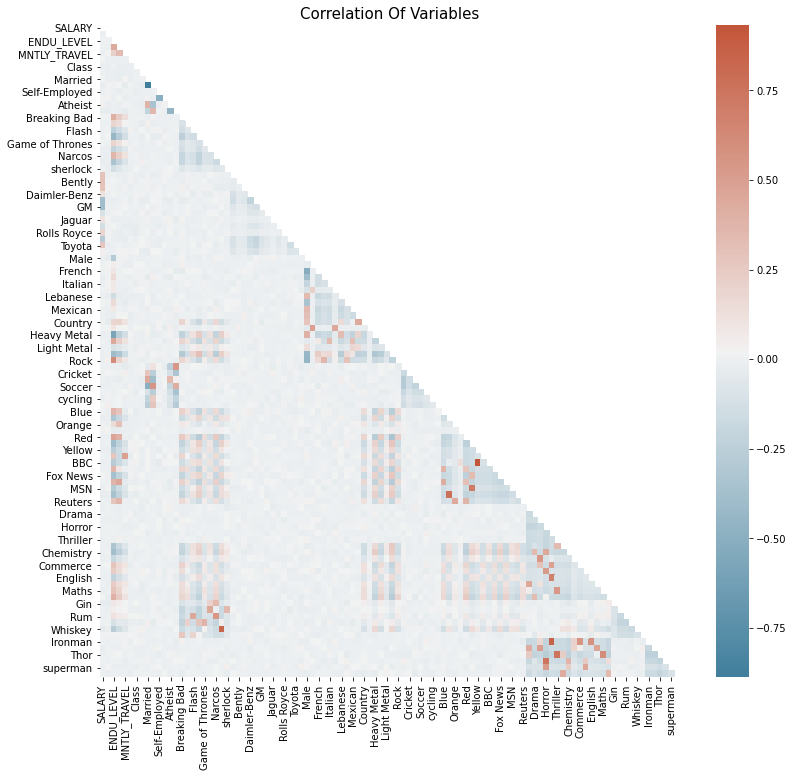

In [149]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 12))

# The correlation variable
corr = hurricane.corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Setting up axes
ax = plt.axes()

fig = sns.heatmap(hurricane.corr(), cmap = cmap, mask = mask, ax = ax)
ax.set_title("Correlation Of Variables", fontsize = 15)

# fig.title("Correlation Of Variables")
# fig = swarm_plot.get_figure()
fig.get_figure().savefig("Correlation_Vars.png")
# fig.savefig(...) 

Most of the variables are not related to each other at all. There may be a few pale patches, but those correlations are still mostly too low to warrant worry. Note that interestingly, although hard to spot, there is a high correlation between watching BBC and liking the color yellow, and another high correlation for drinking whiskey and eating nachos. However, do note that many of these variables appear to be irrelevant towards someone's survival. So let's create a correlation matrix filled with variables that I deem as important.

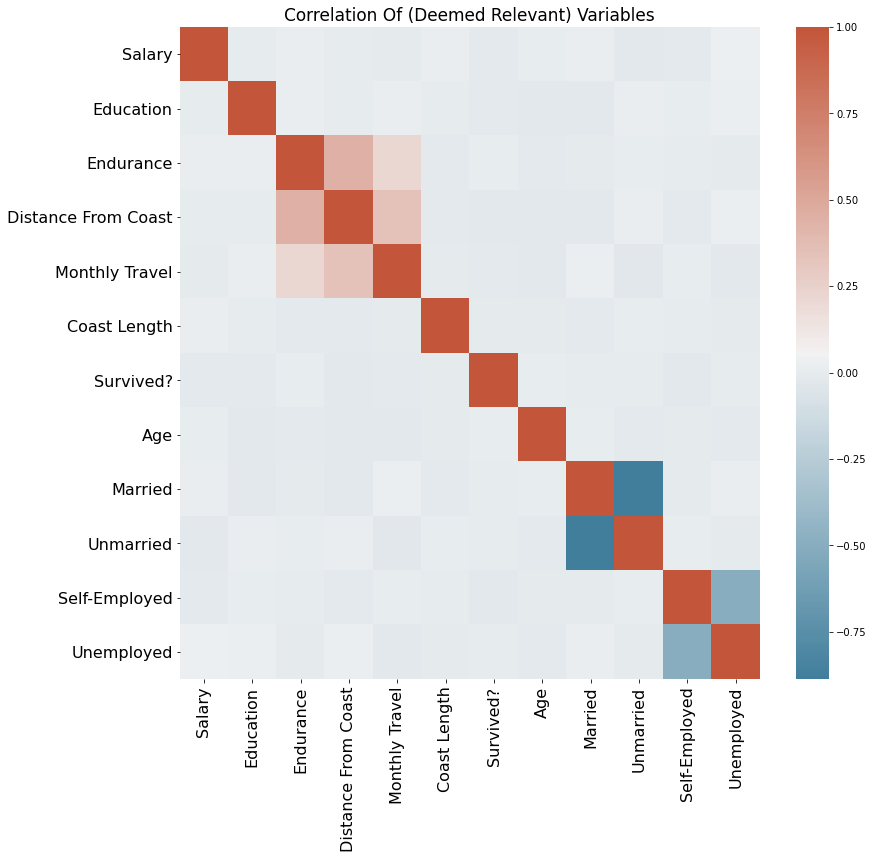

In [150]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 12))

# The correlation variable
corr = (
    hurricane.corr() >>
    select(X.SALARY, X.EDU_DATA, X.ENDU_LEVEL, X.DIST_FRM_COAST, X.MNTLY_TRAVEL,
           X.Dist_Coast,
          X.Class, X.age, X.Married, X.Unmarried, 
           "Self-Employed", X.Unemployed) >>
    row_slice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Setting up axes
ax = plt.axes()

fig = sns.heatmap(corr, cmap = cmap, 
#                   mask = mask, 
                  ax = ax)
ax.set_title("Correlation Of (Deemed Relevant) Variables", 
             fontsize = 17)
axisLabels = ["Salary", "Education", "Endurance", "Distance From Coast", "Monthly Travel",
                            "Coast Length", "Survived?", "Age", "Married", "Unmarried", "Self-Employed", 
                            "Unemployed"]
ax.set_xticklabels(labels = axisLabels,
                   fontsize = 16)
ax.set_yticklabels(labels = axisLabels,
                   fontsize = 16)

# fig.title("Correlation Of Variables")
# fig = swarm_plot.get_figure()
fig.get_figure().savefig("Correlation_Vars1.png", bbox_inches = "tight")



Looking at mainly the traditional demographic variables that I deemed important and ignoring the variables that indicated favorite food/color/car, there seems to be a small positive correlation among endurance level, distance from the coast, and monthly travel. There appears to be a deep negative correlation between unmarried and married, which makes sense as both these categories are mutually exclusive, with an additional reference category (Divorced). The same can be said for the deep negative correlation between self-employment and unemployment.

In [151]:
# Looking at the dataset after spawning dummy variables and implementing inherent ordering.
hurricane.head(6)
# hurricane.age.describe()

,SALARY,EDU_DATA,ENDU_LEVEL,DIST_FRM_COAST,MNTLY_TRAVEL,Dist_Coast,Class,age,Married,Unmarried,...,Rum,Vodka,Whiskey,wine,Ironman,The hulk,Thor,spiderman,superman,wonder woman
0,0,3,2,1,1,462.0,1.0,53.0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1,4,4,2,269.0,1.0,36.0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,1,1,2,1,0,1308.0,0.0,39.0,1,0,...,1,0,0,0,0,0,0,1,0,0
3,2,2,1,0,0,1039.0,1.0,39.0,0,1,...,0,0,0,1,1,0,0,0,0,0
4,3,1,0,1,0,272.0,1.0,49.0,0,1,...,0,1,0,0,0,0,1,0,0,0
5,1,0,2,0,0,603.0,1.0,46.0,0,1,...,0,1,0,0,0,0,1,0,0,0


I notice that we should probably standardize the age and distance of coast variable soon. Age's mean is almost 40 and distance of coast's values range as high as 1500, compared to all the other columns whose values range only in the single digits. 

In [152]:
# from sklearn.preprocessing import LabelEncoder
# for col in hurricane.columns:
#     if hurricane[col].dtypes == object and col in orderedColumns:
#         enc = LabelEncoder()
# #         all_labels = test_x[col].append(train[col])
#         hurricane[col] = enc.fit_transform(hurricane[col])
#         print(enc.classes_.tolist())
# #         train[col] = enc.transform(train[col])
# #         test_x[col] = enc.transform(test_x[col])

## Religion

We have finished categorizing our education levels numerically to ensure correct ordering.

In [153]:
# Agnostic, Atheist, Believer
# hurricane = pd.get_dummies(hurricane, columns = ["REL_ORIEN"], drop_first = True, prefix_sep = "", prefix = "is")
# # Also eradicates the REL_ORIEN variable
# Agnostic is the reference category

In [154]:
# Testing
# df = pd.DataFrame({'Temperature': ['Hot', 'Cold', 'Warm', 'Cold'],
#                    "Religion" : ["Believer", "Agnostic", "Agnostic", "Atheist"]})
# df.head()

# df = pd.get_dummies(df, columns=['Religion'],drop_first=True, prefix_sep = "", prefix = "is")
# df
# # pd.concat([df, pd.get_dummies(df.Religion)], index = df.index)

## Marital Status

In [155]:
# hurricane = pd.get_dummies(hurricane, columns = ["M_STATUS"], drop_first = True, prefix_sep = "", prefix = "is")
# hurricane.dtypes

## Employed

In [156]:
# hurricane = pd.get_dummies(hurricane, columns = ["EMP_DATA"], drop_first = True, prefix_sep = "", prefix = "is")
# hurricane.dtypes

## Gender Variable

In [157]:
# hurricane["GENDER"] = 1.0*(hurricane.GENDER == "Female")
# hurricane.GENDER

In [158]:
# hurricane.age = (
#     hurricane >>
#     select(X.age) >>
#     mutate(age = (X.age - X.age.mean())/X.age.std())
# )
# hurricane.age.describe().round(3)

# Splitting Data

In [159]:
Y = hurricane[["Class"]]
X_vars = hurricane.drop(columns = ["Class"])
X_train, X_test, Y_train, Y_test = train_test_split(X_vars, Y, test_size = 0.3, random_state = 420)

In [160]:
X_train.head(6)

,SALARY,EDU_DATA,ENDU_LEVEL,DIST_FRM_COAST,MNTLY_TRAVEL,Dist_Coast,age,Married,Unmarried,Self-Employed,...,Rum,Vodka,Whiskey,wine,Ironman,The hulk,Thor,spiderman,superman,wonder woman
210,0,0,5,3,3,501.0,50.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4866,0,3,1,3,5,355.0,52.0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
1905,2,1,2,1,1,556.0,44.0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
3312,1,3,0,0,0,1473.0,48.0,1,0,1,...,0,1,0,0,0,1,0,0,0,0
1526,2,1,2,3,5,1021.0,34.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3556,0,3,4,4,1,124.0,49.0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [161]:
X_train.dtypes

SALARY             int8
EDU_DATA           int8
ENDU_LEVEL         int8
DIST_FRM_COAST     int8
MNTLY_TRAVEL       int8
                  ...  
The hulk          int32
Thor              int32
spiderman         int32
superman          int32
wonder woman      int32
Length: 101, dtype: object

The variables are all numbers.

In [162]:
# # Let's learn from the numerical data...but wait we already did that
# # Plot the continuous Variables 
# d = X_train.select_dtypes(include= ["int8", "float64", "uint8"]).melt()
# #d["variable"] = d.columns
# #d["value"] = d["variable"].mean
# p = (
#     d >>
# #     mask(X.variable != "DOB") >>
#     ggplot(aes(x = "value")) +
#     geom_histogram(bins=25) +
#     facet_wrap("variable",scales='free') +
#     labs(
#         x = "Value",
#         y = "Count",
#         title = "Distribution Of Each Numerical Variable"
#     ) +
#     theme(figure_size=(12,12),
#           subplots_adjust={'wspace':0.25,
#                              "hspace": 0.2}) 
# #     theme(axis_text_x = element_text(angle = 90))
# )
# ggsave(plot = p, filename = "Distribution_Numerical_Vars")
# print(p)

In [163]:
def getErrors(y_test, hyp):
    '''
    Calculates some errors like: mean squared error,
    mean absolute error, root mean squared error
    
    @param y_test the test values (from data)
    @param hyp the hypothesized, fitted y-values
    '''
    mse = mean_squared_error(y_test, hyp)
    rmse = np.sqrt(mse) 
    mae = mean_absolute_error(y_test, hyp)
    testError = m.roc_auc_score(y_test, hyp)
    accuracy = accuracy_score(y_test, hyp)
    recallScore = recall_score(y_test, hyp)

    print("MSE: ", round(mse, 3))
    print("RMSE: ", round(rmse, 3))
    print("MAE: ", round(mae, 3))
    print("Test Area Under Curve: ", round(testError, 3))
    print("Accuracy score: ", round(accuracy, 3))
    print("Recall Score: ", round(recallScore, 3))

## Decision Trees

In [164]:
# Fit model
myDT = DT(random_state=420)
myDT.fit(X_train, Y_train)
myDT.score(X_train, Y_train)

1.0

In [165]:
# Doing K-Fold 5-Fold Cross Validation
kf =KFold(n_splits = 5, shuffle = True, random_state = 420)

# Evaluating a score for cross validation
score = cross_val_score(myDT, X_train, Y_train, cv = kf, scoring="accuracy")

# A sorted list of all available metrics to evaluate the cross validation
# sorted(sklearn.metrics.SCORERS.keys())

print(f'Scores for each fold: {score}')
print(f'Mean Score for all folds: {mean(score)}')

Scores for each fold: [0.49206349 0.4963925  0.48340548 0.48196248 0.47907648]
Mean Score for all folds: 0.48658008658008656


In [166]:
# os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin/"
# os.environ["PATH"]

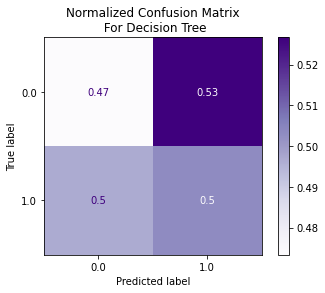

In [167]:
# confusion_matrix(Y_test, myDT.predict(X_test))
fig = m.plot_confusion_matrix(myDT, X_test, Y_test, normalize = "true", cmap = "Purples")
fig.ax_.set_title("Normalized Confusion Matrix\n For Decision Tree")
plt.savefig("Confusion_Matrix_DT.png", bbox_inches = "tight")
plt.show()

It appears that, given how high the true positive and false positive rate, the decision tree tended to label more cases as positive instead of negative. 

In [168]:
getErrors(Y_test, myDT.predict(X_test))
# recall_score(Y_test, myDT.predict(X_test))

MSE:  0.511
RMSE:  0.715
MAE:  0.511
Test Area Under Curve:  0.488
Accuracy score:  0.489
Recall Score:  0.503


Recall score is only about 50%, which means that the ability to accurately identify a positive case (whether individual died) is as good as flipping a coin. Mean squared error is 0.51 and an AUC as 0.488.

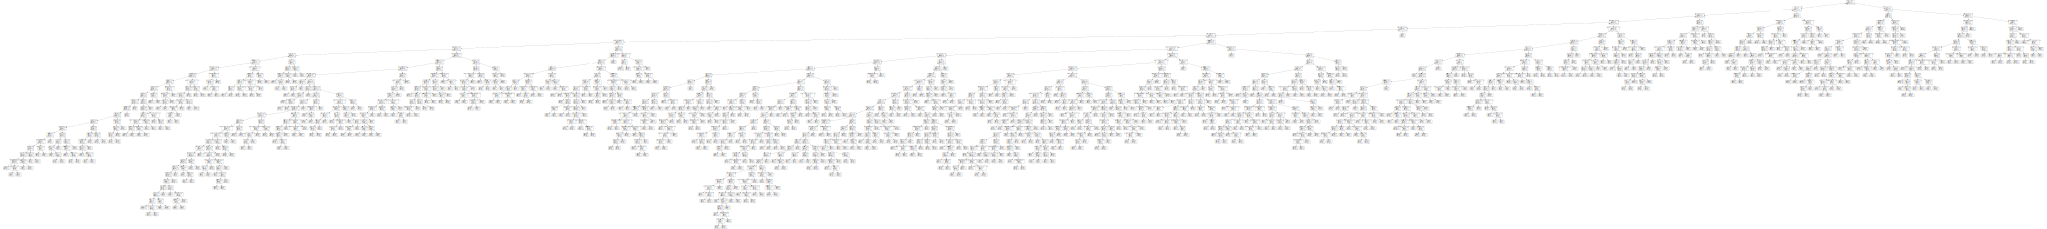

In [169]:
# Visualize the tree in separate file
dot_data = export_graphviz(myDT, out_file=None, feature_names = X_train.columns)
graph = graphviz.Source(dot_data)
graph.render("Hurricane_DT")
graph

That decision tree layout is ridiculously huge and complex.

In [170]:
# print("sorted index: \n", sorted_idx)
# print(X_train.columns[sorted_idx][len(sorted_idx) - 5: len(sorted_idx)])
# print(myDT.feature_importances_[sorted_idx][len(sorted_idx) - 5: len(sorted_idx)])

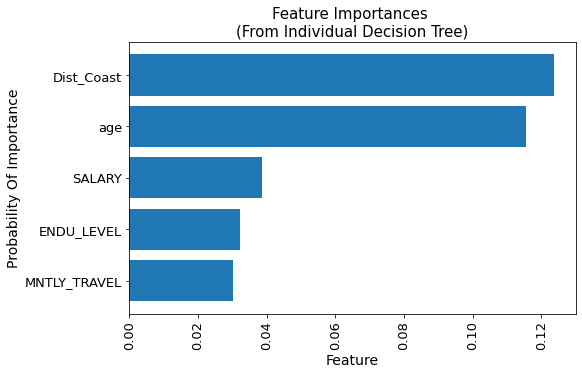

In [171]:
sorted_idx = myDT.feature_importances_.argsort()
important_vars = X_train.columns[sorted_idx][len(sorted_idx) - 5: len(sorted_idx)]
vars_prob_importance = myDT.feature_importances_[sorted_idx][len(sorted_idx) - 5: len(sorted_idx)]

# threshold = 0.025
# important_vars = X_train.columns[myDT.feature_importances_ > threshold].tolist()
# vars_prob_importance = myDT.feature_importances_[myDT.feature_importances_ > threshold]


# Graphing only the most important features
# if their probabilities accurately classifying is at least 2.5%
plt.figure(figsize = (8, 5))
plt.barh(important_vars, 
        vars_prob_importance)
plt.xlabel('Feature', fontsize = 14)
plt.ylabel('Probability Of Importance', fontsize = 14)
plt.title('Feature Importances \n(From Individual Decision Tree)', fontsize = 15)
plt.xticks(rotation = 90, fontsize = 13)
plt.yticks(fontsize = 13)
plt.savefig('Indiv_DT_Feature_Importance.png',
            bbox_inches = "tight"
           )
plt.show()

The most important variables we see are coast length, followed closely by age. Note that the next most important features:  salary, endurance level, and monthly travel, have their importance drastically reduced. But as a whole, distance of coast still does not have the best importance because its probability of accurately predicting whether someone survived or died is still no more than 15%.

In [172]:
# myDT2 = DT(max_depth= 10, random_state= 420)
# myDT2.fit(X_train, Y_train)
# myDT2.score(X_train, Y_train)

In [173]:
# # Doing K-Fold 5-Fold Cross Validation
# kf =KFold(n_splits = 5, shuffle = True, random_state = 420)

# cnt = 1
# # split()  method generate indices to split data into training and test set.
# for train_index, test_index in kf.split(X_train, Y_train):
#     print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
#     cnt += 1

In [174]:
# # Evaluating a score for cross validation
# score = cross_val_score(myDT2, X_train, Y_train, cv = kf, scoring="accuracy")

# # A sorted list of all available metrics to evaluate the cross validation
# # sorted(sklearn.metrics.SCORERS.keys())

# print(f'Scores for each fold: {score}')
# print(f'Mean Score for all folds: {mean(score)}')

## Choosing Best Tree Depth For Decision Tree

In [175]:
param_range = np.arange(1, 15, 1)
train_scores, test_scores = validation_curve(
    DT(), X_train, Y_train, param_name= "max_depth", param_range = param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

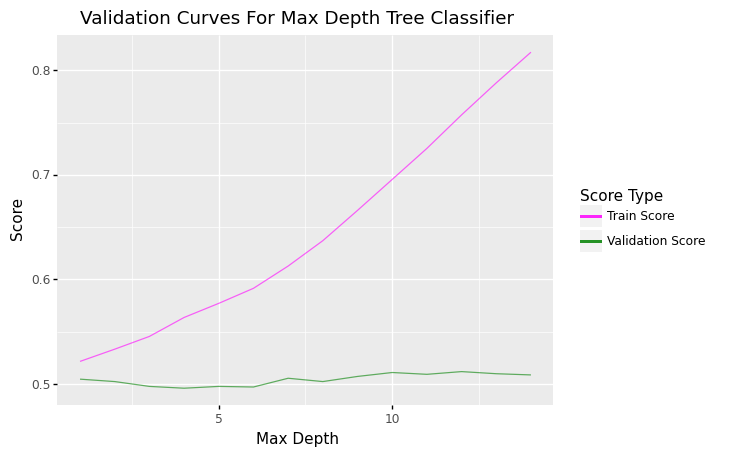

<ggplot: (127915300253)>

In [176]:
validationDF = pd.DataFrame(
list(zip(train_scores_mean, test_scores_mean)),
    columns = ["trainScore", "validationScore"]
)

(
    validationDF >>
    ggplot(aes(x = param_range)) +
    geom_line(aes( y = "trainScore", color = "'magenta'"), alpha = 0.6) +
    geom_line(aes( y = "validationScore", color = "'green'"), alpha = 0.6) +
    labs(
        x = "Max Depth",
        y = "Score",
        title = "Validation Curves For Max Depth Tree Classifier"
    ) +
    # Spawning Separate Legend
    scale_color_identity(guide='legend',name= "Score Type",
                        breaks=['magenta','green'],
                        labels=['Train Score','Validation Score'])
)

The validation scores are barely any better from random chance. Decision Tree does poorly and is drastically overfitting. According to the validation scores, the best depth would be 1 or even 12. Even if we  chose a max depth of 10 to maximize validation score, that increase is a mere tiny bump and not very significant. Since we prefer a simpler model, we prefer max depth as 1.

Note that while the validation scores remain around 50%, the training score increases drastically as max depth increases. This implies that the decision tree model is drastically overfitting.

In [177]:
# Validation curves for important variables, for fun
param_range = np.arange(1, 20, 1)
train_scores, test_scores = validation_curve(
    DT(), (X_train >> select(important_vars)), 
    Y_train, param_name= "max_depth", param_range = param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

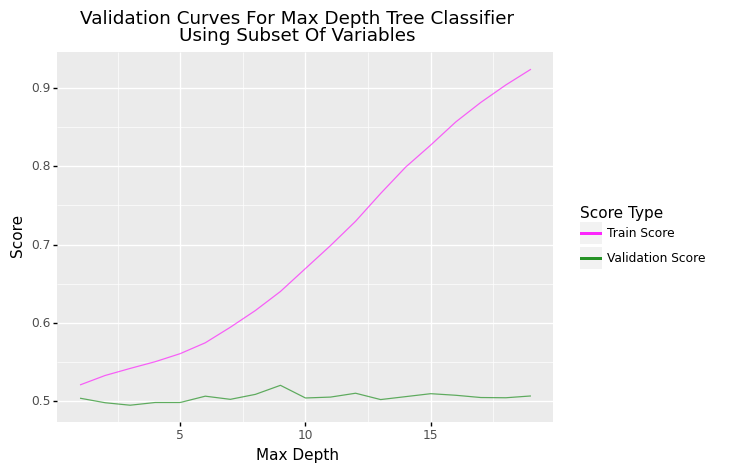

<ggplot: (127926865538)>

In [178]:
validationDF = pd.DataFrame(
list(zip(train_scores_mean, test_scores_mean)),
    columns = ["trainScore", "validationScore"]
)

(
    validationDF >>
    ggplot(aes(x = param_range)) +
    geom_line(aes( y = "trainScore", color = "'magenta'"), alpha = 0.6) +
    geom_line(aes( y = "validationScore", color = "'green'"), alpha = 0.6) +
    labs(
        x = "Max Depth",
        y = "Score",
        title = "Validation Curves For Max Depth Tree Classifier\nUsing Subset Of Variables"
    ) +
    # Spawning Separate Legend
    scale_color_identity(guide='legend',name= "Score Type",
                        breaks=['magenta','green'],
                        labels=['Train Score','Validation Score'])
)

The validation scores are still barely any better from random chance. Decision Tree does poorly and is drastically overfitting. According to the validation scores, even if a max depth of 8 or 12 yields the highest score, the score is not much different than if the max depth were 1. That tiny increase in validation score is not meaningful, so it's better to choose a simpler model.

Note that while validation score averages around 50%, the training score increases drastically as max depth increases. This implies that the decision tree (using subset of important features) is overfitting.

## Random Forest

In [179]:
# Random forest without any hyperparameter tuning
myRF = RF()
myRF.fit(X_train, Y_train)
myRF.score(X_train, Y_train)

1.0

In [180]:
# Evaluating a score for cross validation
score = cross_val_score(myRF, X_train, Y_train, cv = kf, scoring="accuracy")

# A sorted list of all available metrics to evaluate the cross validation
# sorted(sklearn.metrics.SCORERS.keys())

print(f'Scores for each fold: {score}')
print(f'Mean Score for all folds: {mean(score)}')

Scores for each fold: [0.51803752 0.53823954 0.51659452 0.49206349 0.52092352]
Mean Score for all folds: 0.5171717171717172


The mean validation score for all folds is about 51%, about the same score as a coin flip. Random forest is performing poorly.

In [181]:
confusion_matrix(Y_test, myRF.predict(X_test))

array([[333, 398],
       [364, 391]], dtype=int64)

In [182]:
# recall_score(Y_test, myRF.predict(X_test))
getErrors(Y_test, myRF.predict(X_test))

MSE:  0.513
RMSE:  0.716
MAE:  0.513
Test Area Under Curve:  0.487
Accuracy score:  0.487
Recall Score:  0.518


The recall score is 53.6%, about as good as a coin flip. Out of all the positive cases, the model correctly identified only about 53% of them. Out of all the negative cases, the model correclty identified 401/(401 + 382) = 51.21% of the time. Mean squared error is 0.5, with area under curve nearly 0.5, as good as a coin flip. 

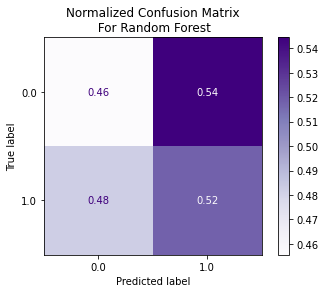

In [183]:
fig = m.plot_confusion_matrix(myRF, X_test, Y_test, normalize = "true", cmap = "Purples")
fig.ax_.set_title("Normalized Confusion Matrix\n For Random Forest")
plt.savefig("Confusion_Matrix_RF.png", bbox_inches = "tight")
plt.show()


Random forest's true positive and true negative rates are just as good as random guessing. Given that it's true positive rate was higher than the false negative rate, and the false positive rate was higher than true negative, random forest appeared to classify more of its cases as positive.

In [184]:
# Grabbing the train and test scores from cross validation
param_range = np.arange(1, 10, 1)
train_scores, test_scores = validation_curve(
    RF(), X_train, Y_train, 
    param_name= "max_depth", param_range = param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

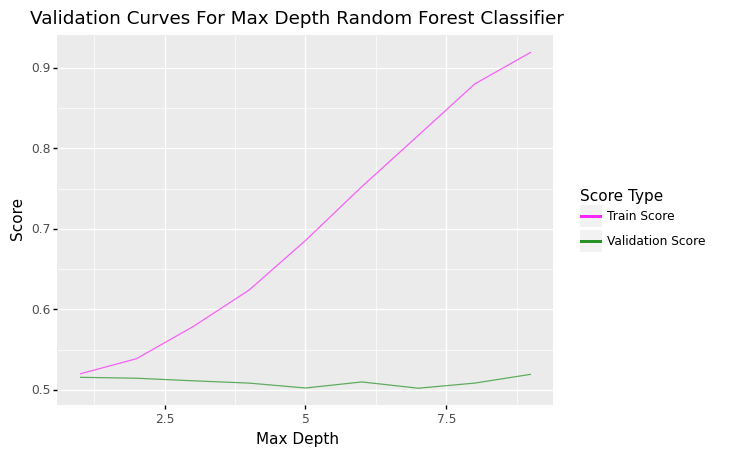

<ggplot: (127926806875)>

In [185]:
# Validation curve for Random Forest For Different Max Depths
validationDF = pd.DataFrame(
list(zip(train_scores_mean, test_scores_mean)),
    columns = ["trainScore", "validationScore"]
)

(
    validationDF >>
    ggplot(aes(x = param_range)) +
    geom_line(aes( y = "trainScore", color = "'magenta'"), alpha = 0.6) +
    geom_line(aes( y = "validationScore", color = "'green'"), alpha = 0.6) +
    labs(
        x = "Max Depth",
        y = "Score",
        title = "Validation Curves For Max Depth Random Forest Classifier"
    ) +
    # Spawning Separate Legend
    scale_color_identity(guide='legend',name= "Score Type",
                        breaks=['magenta','green'],
                        labels=['Train Score','Validation Score'])
)

Validation scores barely improve for different max depths of random forest. Since we prefer a simpler model, the max depth should be 1. Note that as the max depth increases, so does the train score, which implies that the random forest model is drastically overfitting.

In [186]:
# print(sorted_idx)
# print(len(sorted_idx))
# print(myRF.feature_importances_[sorted_idx][len(sorted_idx) - 5:len(sorted_idx)])

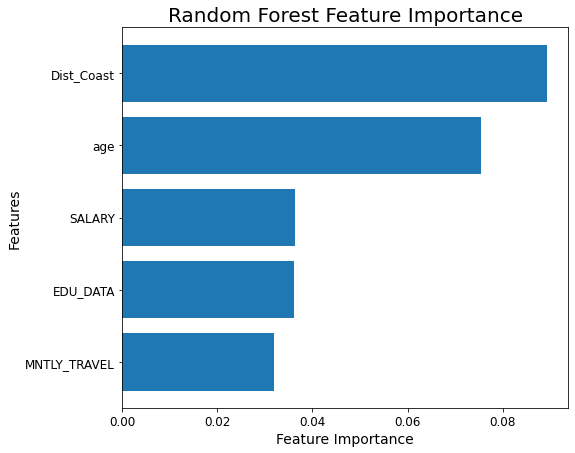

In [187]:
sorted_idx = myRF.feature_importances_.argsort()
plt.figure(figsize = (8, 7))
# topIndexFeatures = 
plt.barh(X_train.columns[sorted_idx][len(sorted_idx) - 5:len(sorted_idx)], myRF.feature_importances_[sorted_idx][len(sorted_idx) - 5:len(sorted_idx)])

plt.xlabel("Feature Importance", fontsize = 14)
plt.ylabel("Features", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Random Forest Feature Importance", fontsize = 20)
plt.savefig("Indiv_RF_Feature_Importance.png", bbox_inches = "tight")
plt.show()

According to the random forest feature importance, coastal length is the most important feature, followed closely by age. The rest of the features have about half the importance or less. Note that the top 5 important features mostly mirror the decision tree's chosen important features, and that both models scored coastal length as the most important, followed closely by age.

## Linear Discriminant Analysis

In [188]:
# LDA without any hyperparameter tuning
myLDA = LDA()
myLDA.fit(X_train, Y_train)
myLDA.score(X_train, Y_train)

0.5757575757575758

This score is significantly lower than the non-parametric models. This implies that this parametric model LDA could be too simple (non-parametric models tend to be more complex than parametric models).

In [189]:
# Evaluating a score for cross validation
score = cross_val_score(myLDA, X_train, Y_train, cv = kf, scoring="accuracy")

# A sorted list of all available metrics to evaluate the cross validation
# sorted(sklearn.metrics.SCORERS.keys())
print(f'Scores for each fold: {score}')
print(f'Mean Score for all folds: {mean(score)}')

Scores for each fold: [0.52813853 0.54689755 0.48773449 0.48917749 0.51659452]
Mean Score for all folds: 0.5137085137085137


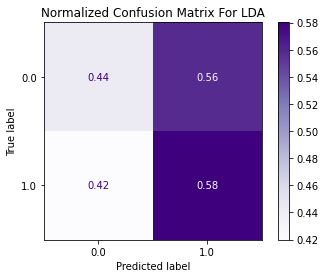

In [190]:
# Confusion Matrix
# confusion_matrix(Y_test, myLDA.predict(X_test))
fig = m.plot_confusion_matrix(myLDA, X_test, Y_test, normalize = "true", cmap = "Purples")
fig.ax_.set_title("Normalized Confusion Matrix For LDA")
plt.savefig("Confusion_Matrix_LDA.png", bbox_inches = "tight")
plt.show()


In [191]:
recall_score(Y_test, myLDA.predict(X_test))

0.5801324503311258

Out of all the positive classes, LDA did better than the other non-parametric models (decision trees, random forest) in correctly classifying them. LDA correctly classified positive cases about 58% of the time. That recall score by itself is still suboptimal, though.

## XGBoost

In [192]:
# Tutorial: https://www.datacamp.com/community/tutorials/xgboost-in-python
data_dmatrix = xgb.DMatrix(data=X_vars,label=Y)
data_dmatrix

#### Hyperparameters

- `learning_rate`: step size shrinkage to stop overfitting Range: [0, 1]
- `max_depth`: how deep the tree will grow during boosting
- `subsample`: % of samples used per tree. Low value can lead to underfitting.
- `colsample_bytree`: % features used per tree. High value = overfitting
- `n_estimators`: Number of trees to build
- `objective`: Loss function, like `reg:linear` for regression problems, `reg:logistic` for classification (with decision), `binary:logistic` for classification with probability/confidence

- `gamma`: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
- `alpha`: L1 regularization on leaf weights. A large value leads to more regularization.
- `lambda`: L2 regularization on leaf weights and is smoother than L1 regularization.


In [193]:
myXGB = xgb.XGBClassifier(objective = "reg:logistic", colsample_bytree = 0.3, 
                          learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
myXGB.fit(X_train, Y_train)
myXGBPred = myXGB.predict(X_test)

In [194]:
len(myXGBPred) == len(Y_test)

True

In [195]:
print("xgb train score: ", myXGB.score(X_train, Y_train))
getErrors(Y_test, myXGBPred)
confusion_matrix(Y_test, myXGBPred)
# m.plot_confusion_matrix(myXGB, X_test, myXGBPred, normalize = "true")
# plt.show()

xgb train score:  0.5956709956709957
MSE:  0.5
RMSE:  0.707
MAE:  0.5
Test Area Under Curve:  0.497
Accuracy score:  0.5
Recall Score:  0.702


array([[213, 518],
       [225, 530]], dtype=int64)

The area under the curve for this individual xgboost is still barely 0.5. Its recal score is surprisingly high though. Given that a case is positive, xgboost can accurately label it 70.2% of the time. But given that the case is negative, individual xgboost cannot easily accurately label it as negative.

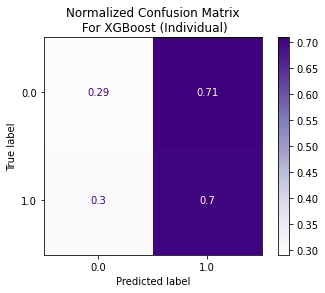

In [196]:
fig = m.plot_confusion_matrix(myXGB, X_test, Y_test, normalize = "true", cmap = "Purples")
fig.ax_.set_title("Normalized Confusion Matrix\n For XGBoost (Individual)")
plt.savefig("Confusion_Matrix_Indiv_xgboost.png", bbox_inches = "tight")
plt.show()

Xgboost still had poor predictive accuracy when it comes to negative cases but mediocre predictive accuracy for positive cases. It appears that the individual xgboost model gave out more positive labels than negative labels, since both its false positive and true positive rates are high.

## K-Fold Cross Validation Using Xgboost

In [197]:
params = {"objective":"reg:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed= 420)

In [198]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.499571,0.000119,0.499845,0.000063
1,0.499286,0.000057,0.499819,0.000089
2,0.499012,0.000117,0.499831,0.000049
3,0.498587,0.000169,0.499822,0.000090
4,0.498132,0.000192,0.499799,0.000072


### Visualizing The Boosting Tree

<Figure size 5000x1200 with 0 Axes>

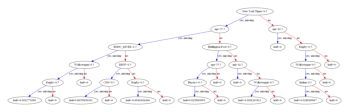

In [199]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
plt.figure(figsize=(50, 12), dpi= 100)
xgb.plot_tree(xg_reg,num_trees=0, height = 20)
# plt.rcParams['figure.figsize'] = [50, 12]
plt.show()

This boosting tree plot gives insight into how the model arrived at its final decisions and what splits it made to arrive at those decisions. It appears that age appeared high in the tree, so age appears to be an important feature in determining survival. Surprisingly, having a penchance for reading New York Times is also very important in predicting a residents' survival. I notice that although decision tree declared distance of the coast as important, it is not displayed in the xgboost feature importance tree.

### Visualizing Feature Importance

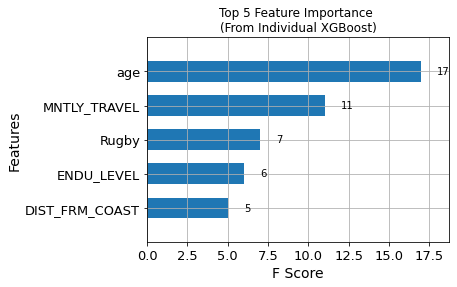

In [200]:
ax = xgb.plot_importance(xg_reg, title = "Top 5 Feature Importance \n(From Individual XGBoost)",
                        max_num_features = 5,
                        height = 0.6)
# plt.rcParams['figure.figsize'] = 10,10
ax.figure.tight_layout()
ax.figure.savefig("Indiv_xgboost_feature_importance.png", bbox_inches = "tight", dpi = 80)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("F Score", fontsize = 14)
plt.ylabel("Features", fontsize = 14)
# xgb.plot_importance(xg_reg)
# plt.figure(figsize=(4, 4))
# plt.rcParams['figure.figsize'] = [10, 12]
# plt.savefig("Indiv_xgboost_feature_importance.png", bbox_inches = "tight", dpi = 100)
plt.show()

According to the feature importance plot, age is the most important feature with the highest importance score, followed by monthly travel, then by having rugby as a favorite sport, then endurance level. 

## Pipeline

In [211]:
# Running A pipelin

# (0) Split the data 
X_train, X_test, Y_train, Y_test = train_test_split(X_vars, Y, test_size = 0.3, random_state = 420)
# try random_state: 202011

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits = 10, shuffle=True, random_state = 420)

# (2) Next specify the preprocessing steps
# min-max scale these 3 variables: Records, Job, Debt, Income, Home 
preprocess = ColumnTransformer(transformers=[('num', pp.Normalizer(),
                # Including which variables...
                important_vars)])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
# spawn a preprocess object
# leave model as blank...cuz we're gonna spawn one eventually...
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])
# pipe = Pipeline([
#     ('model',None)
# ])
# fun fact: we don't even have to use the word "model" We could use a random name, like "duck"
# or "P'Dean"

# but please, "model" is a place_holder.
# You change the weird "model" into "P'Dean", you'll have to write "P'Dean"

# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    
    
    
    
    # Gaussian Naive Bayes
    {'model' : [NB()]
    
    },
    
    # Linear Model
    #{'model' : [LM()]},
    # Actually, don't use a linear model. Because we are classifying, 
    # Not regressing (numeric predictions)
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30],
     'model__leaf_size' : [10, 20, 30, 40]
    }, # Notice the double underscore after model
    
    # KNN with K tuning param
#     {'model' : [Lasso()],
# #      'model__n_neighbors':[10,15,20,25,30],
#      'model__alpha' : [0, 0.005, 0.01, 0.015, 0.02]}, # Notice the double underscore after model
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[1, 5, 10, 15],
    "model__min_samples_leaf" : [1, 5, 7, 9]    
    },
    
    
    # The Bagging decision tree model 
    #{'model': [Bag()]},
    
    # Random forest (Classifier) with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1, 5, 10, 15],
     'model__n_estimators':[100, 500, 1000, 1500]
     
    },
    
    # XGBoost
    {"model" : [xgb.XGBClassifier()],
     "model__objective" : ["reg:logistic"], 
     "model__colsample_bytree" : [0.1, 0.3, 0.5], 
     "model__learning_rate" : [0.3, 0.5, 0.8], 
     "model__max_depth" : [5, 10, 15],
     "model__reg_alpha" : [5, 10, 15],
     "model__reg_lambda" : [5, 10, 15], 
     "model__n_estimators" : [5, 10, 15]
    },
]


# (5) Put it all together in the grid search
# search_space was the tuing parameters or something
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs = -1)

# (6) Fit the model to the training data
search.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=420, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         Normalizer(),
                                                                         Index(['MNTLY_TRAVEL', 'ENDU_LEVEL', 'SALARY', 'age', 'Dist_Coast'], dtype='object'))])),
                                       ('model', None)]),
             n_jobs=-1,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__le...
                                                  scale_pos_weight=None,
                                                  subsample=None,
                                                  tree_method=None,
                                                  validate_parameters=None,
                             

In [213]:
search.best_params_

{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=0.5, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.8, max_delta_step=None, max_depth=10,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=5, n_jobs=None, num_parallel_tree=None,
               objective='reg:logistic', random_state=None, reg_alpha=5,
               reg_lambda=5, scale_pos_weight=None, subsample=None,
               tree_method=None, validate_parameters=None, verbosity=None),
 'model__colsample_bytree': 0.5,
 'model__learning_rate': 0.8,
 'model__max_depth': 10,
 'model__n_estimators': 5,
 'model__objective': 'reg:logistic',
 'model__reg_alpha': 5,
 'model__reg_lambda': 5}

The best model is xgboost. It has a learning rate of 0.8, a max depth of 5, 10 estimators, and an alpha and lambda regularization constant of 5.

In [214]:
search.best_score_

-0.47127317552597814

In [215]:
rf_mod = search.best_estimator_
rf_mod

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num', Normalizer(),
                                                  Index(['MNTLY_TRAVEL', 'ENDU_LEVEL', 'SALARY', 'age', 'Dist_Coast'], dtype='object'))])),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.8,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=5,
                               n_jobs=8, num_parallel_tree=1,
                               objective='reg:logistic', random_state=0,
                               reg_alpha=5, reg_lamb

In [216]:
# print("Training score:", m.roc_auc_score(Y_train, rf_mod.predict(X_train)))
# print("Testing score:", m.roc_auc_score(Y_test, rf_mod.predict(X_test)))

getErrors(Y_test, rf_mod.predict(X_test))

MSE:  0.52
RMSE:  0.721
MAE:  0.52
Test Area Under Curve:  0.479
Accuracy score:  0.48
Recall Score:  0.55


Mean squared error is barely 0.5. Although that seems low, remember that the outcome variable is either 0 or 1, so a mean squared error of 0.5 is still significant. Recall score is about 59%. This xgboost model correctly identified positive (death) cases slightly better than a coin flip.

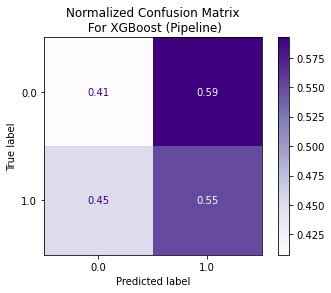

In [217]:
fig = m.plot_confusion_matrix(rf_mod, X_test, Y_test, normalize = "true", cmap = "Purples")
fig.ax_.set_title("Normalized Confusion Matrix\n For XGBoost (Pipeline)")
plt.savefig("Confusion_Matrix_Pipeline_xgboost.png", bbox_inches = "tight")
plt.show()

The false positive rate is significantly higher than the true negative rate, and the true positive rate is higher than the false negative rate. It appears that the pipeline xgboost model tended to give out more positive labels to cases than negative labels.

In [218]:
vi = permutation_importance(rf_mod, X_train,Y_train, n_repeats = 30, random_state = 420) 
# Try not to shuffle the data in a way that the model does surprisingly better. Or worse.
# SO do more repeats.

# We have data togeher...
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable= X_train.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std'] # 2 STDs below mean
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std'] # 2 STDs above mean.

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,Dist_Coast,0.147532,0.007203,0.133127,0.161938
1,age,0.104416,0.006495,0.091425,0.117407
2,MNTLY_TRAVEL,0.051304,0.005893,0.039517,0.063090
3,SALARY,0.041857,0.004546,0.032764,0.050949
4,ENDU_LEVEL,0.003242,0.000999,0.001244,0.005240
...,...,...,...,...,...
96,Wolkswagen,0.000000,0.000000,0.000000,0.000000
97,Toyota,0.000000,0.000000,0.000000,0.000000
98,Suzuki,0.000000,0.000000,0.000000,0.000000
99,Rolls Royce,0.000000,0.000000,0.000000,0.000000


In [236]:
top5Var

,variable,vi,std,low,high
0,Dist_Coast,0.147532,0.007203,0.133127,0.161938
1,age,0.104416,0.006495,0.091425,0.117407
2,MNTLY_TRAVEL,0.051304,0.005893,0.039517,0.063090
3,SALARY,0.041857,0.004546,0.032764,0.050949
4,ENDU_LEVEL,0.003242,0.000999,0.001244,0.005240


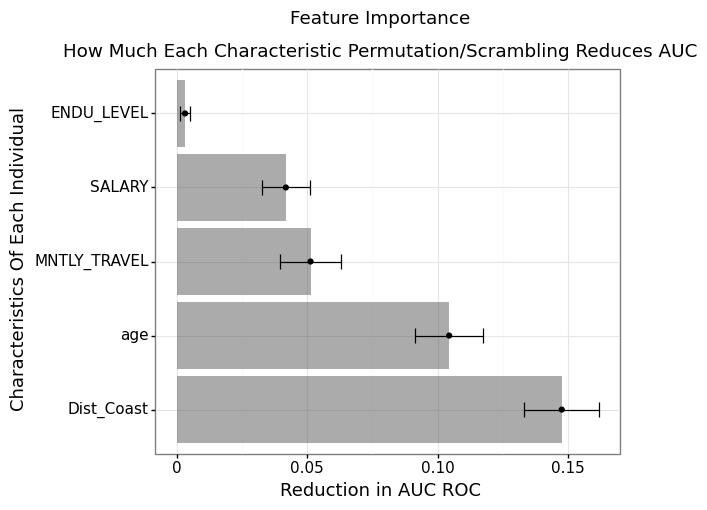

<ggplot: (127917119492)>


In [238]:
# Plot these permutations

top5Var = vi_dat.query("vi > 0.0020").sort_values("vi", ascending = False)
# (
#     vi_dat >>
#     mask(X.vi > 0.0025) >>
#     arrange(X.vi, ascending = False)
# )
p = (
    top5Var >>
    ggplot(
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    
    # Error bars
    geom_errorbar(aes(ymin="low", ymax="high"), width=.2) +
    theme_bw() +
    
    # Ordering the variables by level of importance
    scale_x_discrete(limits = top5Var.variable.tolist()) +
    coord_flip() +
    
    labs(
        y="Reduction in AUC ROC",
        x="Characteristics Of Each Individual",
        title = "Feature Importance\n\nHow Much Each Characteristic Permutation/Scrambling Reduces AUC"
    ) +
#     scale_x_discrete(
#          breaks = ["ENDU_LEVEL", "SALARY", "MNTLY_TRAVEL", "age", "Dist_Coast"],
#         labels = ["Endurance", "Salary", "Monthly Travel", "Age", "Coastal Length"]
#     ) +
    
    theme(axis_text = element_text(color = "black", size = 11)) +
    theme(axis_title = element_text(color = "black", size = 13)) +
    theme(figure_size=(6, 5))  # here you define the plot size
)
# ggsave(plot = p, filename = "Data-Important_Variables")
print(p)

The most important features are, in order: `Dist_Coast`,`age`, followed by `MNTLY_TRAVEL`, `ENDU_DATA`, and `SALARY`. But overall, these variables are not very important. Even distance of the coast, the variable that can reduce the most AUC, at best reduces the AUC at around 15%. Permuting age, the next most significant feature, decreases the area under the ROC curve by about 10%. The rest of the features reduce the AUC even less significantly, so they are overall not very important.

In [220]:
cv_results["test-rmse-mean"].tail(4)

1    0.499819
2    0.499831
3    0.499822
4    0.499799
Name: test-rmse-mean, dtype: float64

I noticed that my rmse is lower than before.

## Viewing Model Performance Of All Models Together At A Glance

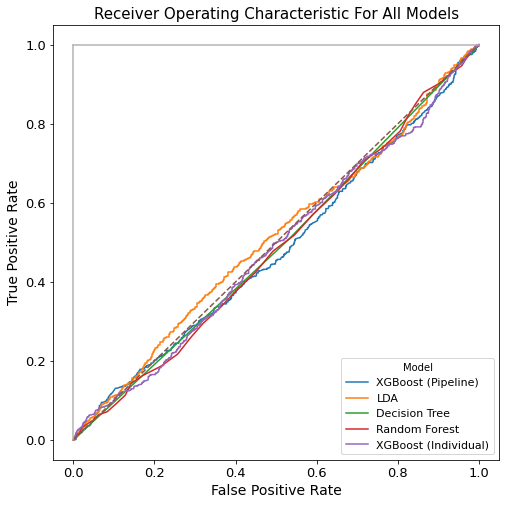

In [221]:
# Getting the false positive and true positive rates for each model
rfYScore = rf_mod.predict_proba(X_test)[:,1]

# False positive, true positive for the chosen pipline model: XGBoost
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, rfYScore)
fpLDA, tpLDA, thresholdLDA = roc_curve(Y_test, myLDA.predict_proba(X_test)[:, 1]) # LDA
fpXGB, tpXGB, thresholdXGB = roc_curve(Y_test, myXGB.predict_proba(X_test)[:, 1]) # individual XGBoost
fpDT, tpDT, thresholdDT = roc_curve(Y_test, myDT.predict_proba(X_test)[:, 1]) # Decision Tree
fpRF, tpRF, thresholdRF = roc_curve(Y_test, myRF.predict_proba(X_test)[:, 1]) # Random forest

# Plotting
plt.subplots(1, figsize=(8,8))

# Pipeline's XGBoost
plt.plot(false_positive_rate1, true_positive_rate1, label = "XGBoost (Pipeline)")

# LDA
plt.plot(fpLDA, tpLDA, label = "LDA")
# Decision Tree
plt.plot(fpDT, tpDT, label = "Decision Tree")

# Random Forest
plt.plot(fpRF, tpRF, label = "Random Forest")

# XGBoost
plt.plot(fpXGB, tpXGB, label = "XGBoost (Individual)")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")

# Labels
plt.title('Receiver Operating Characteristic For All Models', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.xlabel('False Positive Rate', fontsize = 14)

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(title = "Model", fontsize = 11)
plt.savefig('ROC_Curves_All_Models.png', bbox_inches = "tight", dpi = 100)
plt.show()
# Saving the figure into a picture

# ggsave()

According to the ROC curve, the XGBoost model (chosen from the pipeline) correctly classified positive cases only about 50% of the time, barely better than a coin flip. In fact, all of these models were terrible in predicting positive cases and were marginally better than random guessing.

In [222]:
# def getFeatureImportanceDF(modelList, modelNamesList, columnNames = X_train.columns):
#     '''
#     Creates a feature importance dataframe. Each row represents a model and its
#     top 2 important features
    
#     @param modelList a list of model objects
#     @param modelNamesList a list of model String names
#     @return the feature importance dataframe
#     '''
    
#     models = []
    
#     for index in range(len(modelList)):
#         model = modelList[index]
#         modelName = modelNamesList[index]
        
#         sorted_idx = model.feature_importances_.argsort()
        
#         firstImportantVar = columnNames[sorted_idx][len(sorted_idx) - 1]
#         secondImportantVar = columnNames[sorted_idx][len(sorted_idx) - 2]
        
#         row = [modelName, firstImportantVar, secondImportantVar]
        
#         models.append(row)
    
#     featureImportanceDF = pd.DataFrame(models, columns = ["Model", "Most Important Feature", "Second Most Important Feature"])
#     return featureImportanceDF
    
        
        
# modelList = [myDT, myRF, myXGB]
# modelNamesList = ["Decision Tree", "Random Forest", "XGBoost\n(Individual)"]
# featureImportanceDF = getFeatureImportanceDF(modelList, modelNamesList)
# featureImportanceDF

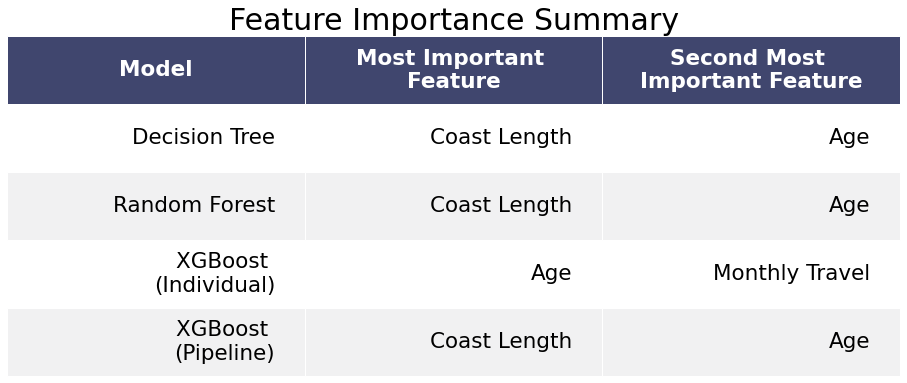

In [223]:
featureImportanceDF = pd.DataFrame({
    "Model" : ["Decision Tree", "Random Forest", "XGBoost \n(Individual)", "XGBoost \n(Pipeline)"],
    "Most Important \nFeature" : ["Coast Length", "Coast Length", "Age", "Coast Length"],
    "Second Most \nImportant Feature": ["Age", "Age", "Monthly Travel", "Age"]
})

fig,ax = render_mpl_table(featureImportanceDF, header_columns=0, col_width=2.0, font_size = 21.5)
plt.title("Feature Importance Summary", fontsize = 30)
fig.savefig("Feature_Importance_Summary.png", bbox_inches = "tight")

In [228]:
# getErrors(Y_test, myDT.predict(X_test))

# performanceDF = pd.DataFrame(columns = ["Model", "MSE", "RMSE", "MAE", "AUC", "Accuracy", "Recall", "Validation Score"])

def getPerformanceDF(modelList, modelNamesList, digits = 3):
    '''
    Creates a dataframe/table summarizing model performance metrics for each model
    
    @param modelList a list of model objects
    @param modelNamesList a lit of model String names
    @return a dataframe/table metric summary
    '''

    modelListDF = []

    # For every model, calculate all the metrics
    for index in range(len(modelList)):
        model = modelList[index]
        modelName = modelNamesList[index]
        hyp = model.predict(X_test)

        # Getting the metrics
        mse = mean_squared_error(Y_test, hyp)
        rmse = np.sqrt(mse) 
        mae = mean_absolute_error(Y_test, hyp)
        auc = m.roc_auc_score(Y_test, hyp)
        accuracy = accuracy_score(Y_test, hyp)
        recallScore = recall_score(Y_test, hyp)
        trainScore = model.score(X_train, Y_train)
        validScore = mean(cross_val_score(model, X_train, Y_train, cv = kf, scoring="accuracy"))
        row = [modelName, mse, rmse, mae, auc, accuracy, recallScore, trainScore, validScore]
        modelListDF.append(row)
        
        # Getting validation score
    performanceDF = pd.DataFrame(modelListDF, columns = ["Model", "MSE", "RMSE", "MAE", "AUC", "Accuracy", "Recall", "Train Score","Validation"])
    return round(performanceDF, digits)


modelList = [myDT, myRF, myLDA, myXGB, rf_mod]
modelNamesList = ["Decision Tree", "Random \nForest", "LDA", "XGBoost\n(Individual)", "XGBoost \n(Pipeline)"]

performanceDF = getPerformanceDF(modelList, modelNamesList)
performanceDF

,Model,MSE,RMSE,MAE,AUC,Accuracy,Recall,Train Score,Validation
0,Decision Tree,0.511,0.715,0.511,0.488,0.489,0.503,1.000,0.487
1,Random \nForest,0.513,0.716,0.513,0.487,0.487,0.518,1.000,0.518
2,LDA,0.488,0.698,0.488,0.511,0.512,0.580,0.576,0.514
3,XGBoost\n(Individual),0.500,0.707,0.500,0.497,0.500,0.702,0.596,0.511
4,XGBoost \n(Pipeline),0.520,0.721,0.520,0.479,0.480,0.550,0.657,0.509


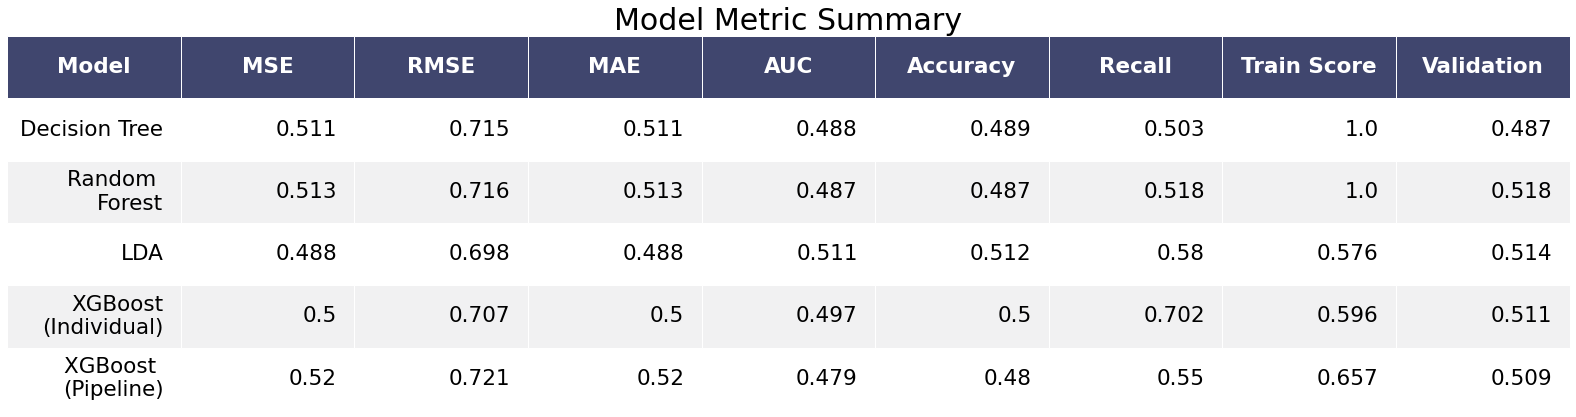

In [229]:
# Creating a table and saving it as an image
fig,ax = render_mpl_table(performanceDF, header_columns=0, col_width=2.0, font_size = 21.5)
plt.title("Model Metric Summary", fontsize = 30)
fig.savefig("Model_Metric_Summary.png", bbox_inches = "tight")
# render_mpl_table(performanceDF)

The pipeline xgboost had the highest MSE and almost tied with Decision Tree in RMSE and MAE. LDA had the best AUC and accuracy, though that does not mean LDA is amazing at predicting given that the lowest AUC was not far away from LDA's AUC. The individual xgboost had a surprisingly high recall compared to other models, indicating this accurately classifies positive cases relatively well. What's even more surprising is that the chosen xgboost from the pipeline had a low recall score of 0.576, unfortunately. LDA had the highest validation of 0.514 and decision tree had the lowest validation of 0.495.

My models generally classified poorly. For each metric, none of the models did distinctly well except for the recall score for xgboost. Xgboost's recall score was significantly relatively higher than all the other models' recall score. 